In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
# Loading datasets
train_df = pd.read_csv(r"C:\Users\sg200\Downloads\train_u6lujuX_CVtuZ9i.csv")
test_df = pd.read_csv(r"C:\Users\sg200\Downloads\test_Y3wMUE5_7gLdaTN.csv")


In [4]:
print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Test: {test_df.shape}")
print("\nTraining data info:")
print(train_df.info())

Dataset shapes:
Training: (614, 13)
Test: (367, 12)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


In [5]:
class LoanDataPreprocessor:
    def __init__(self):
        self.numeric_imputer = SimpleImputer(strategy='median')
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.scaler = StandardScaler()
        self.label_encoders = {}

In [6]:
 def preprocess(self, df, is_train=True):
        df_processed = df.copy()
        
        # Store Loan_ID for submission
        loan_ids = df_processed['Loan_ID'] if 'Loan_ID' in df_processed.columns else None
        
        # Handle Dependents column
        df_processed['Dependents'] = df_processed['Dependents'].replace('3+', '3')
        
        # Convert to appropriate data types
        numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
        categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                          'Self_Employed', 'Credit_History', 'Property_Area']

        for col in numeric_cols:
            if col in df_processed.columns:
                #feature engineering
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

      # Handle missing values
        df_processed = self._handle_missing_values(df_processed, numeric_cols, categorical_cols, is_train)
        
        # Encode categorical variables
        df_processed = self._encode_categorical(df_processed, categorical_cols, is_train)
        
        # Scale numerical features
        numerical_features = [col for col in df_processed.columns 
                           if col not in ['Loan_ID', 'Loan_Status'] + categorical_cols 
                           and df_processed[col].dtype in ['int64', 'float64']]

        if is_train:
            df_processed[numerical_features] = self.scaler.fit_transform(df_processed[numerical_features])
        else:
            df_processed[numerical_features] = self.scaler.transform(df_processed[numerical_features])
        
        return df_processed.drop('Loan_ID', axis=1) if 'Loan_ID' in df_processed.columns else df_processed


         

In [7]:
    def _create_features(self, df):
        """Create advanced features for better prediction"""
        # Total income
        df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
        
        # Income to loan ratio
        df['IncomeToLoanRatio'] = df['TotalIncome'] / (df['LoanAmount'] + 1)
        
        # EMI (assuming 8.5% interest rate)
        df['EMI'] = df['LoanAmount'] * 0.0085 * (1 + 0.0085)**df['Loan_Amount_Term'] / ((1 + 0.0085)**df['Loan_Amount_Term'] - 1 + 1e-8)

          # EMI to income ratio
        df['EMIToIncomeRatio'] = df['EMI'] / (df['TotalIncome'] + 1)
        
        # Loan amount to income ratio
        df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['TotalIncome'] + 1)
        
        # Has co-applicant
        df['HasCoapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)
        
        # Income stability score (higher is better)
        df['IncomeStability'] = df['ApplicantIncome'] / (df['CoapplicantIncome'] + 1)

           # Log transformations for skewed features
        df['LogApplicantIncome'] = np.log1p(df['ApplicantIncome'])
        df['LogLoanAmount'] = np.log1p(df['LoanAmount'])
        df['LogTotalIncome'] = np.log1p(df['TotalIncome'])
        
        return df
         

In [8]:
def _handle_missing_values(self, df, numeric_cols, categorical_cols, is_train):
    """Handle missing values with appropriate strategies"""

    # Handle numerical missing values
    numerical_missing = [col for col in numeric_cols if col in df.columns and df[col].isnull().any()]
    if numerical_missing:
        if is_train:
            df[numerical_missing] = self.numeric_imputer.fit_transform(df[numerical_missing])
        else:
            df[numerical_missing] = self.numeric_imputer.transform(df[numerical_missing])

    # Handle categorical missing values
    categorical_missing = [col for col in categorical_cols if col in df.columns and df[col].isnull().any()]
    if categorical_missing:
        if is_train:
            df[categorical_missing] = self.categorical_imputer.fit_transform(df[categorical_missing])
        else:
            df[categorical_missing] = self.categorical_imputer.transform(df[categorical_missing])

    return df


In [9]:
    def _encode_categorical(self, df, categorical_cols, is_train):
        """Encode categorical variables"""
        for col in categorical_cols:
            if col in df.columns:
                if is_train:
                    le = LabelEncoder()
                    df[col] = le.fit_transform(df[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    le = self.label_encoders.get(col)
                    if le is not None:
                        # Handle unseen categories in test set
                        unseen_mask = ~df[col].astype(str).isin(le.classes_)
                        if unseen_mask.any():
                            df.loc[unseen_mask, col] = le.classes_[0]  # Use most frequent category
                        df[col] = le.transform(df[col].astype(str))
        return df

        


In [10]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

class LoanDataPreprocessor:
    def __init__(self):
        self.numeric_imputer = SimpleImputer(strategy='median')
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')

In [11]:
# Preprocess method definition
def preprocess(self, df, is_train=True):
    # Define original columns for imputation before feature engineering
    original_numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
    original_categorical_cols = [col for col in df.columns 
                                 if col not in original_numeric_cols + ['Loan_ID', 'Loan_Status']
                                 and df[col].dtype == 'object']

    # Impute numerical columns
    if is_train:
        df[original_numeric_cols] = self.numeric_imputer.fit_transform(df[original_numeric_cols])
    else:
        df[original_numeric_cols] = self.numeric_imputer.transform(df[original_numeric_cols])

    # Impute categorical columns
    if is_train:
        df[original_categorical_cols] = self.categorical_imputer.fit_transform(df[original_categorical_cols])
    else:
        df[original_categorical_cols] = self.categorical_imputer.transform(df[original_categorical_cols])

    # Feature engineering: add new features
    df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['LoanAmount_log'] = np.log(df['LoanAmount'])

    # One-hot encode categorical variables
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in ['Loan_ID', 'Loan_Status']]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Drop Loan_ID column if present
    if 'Loan_ID' in df.columns:
        df = df.drop('Loan_ID', axis=1)

    return df

# Attach method to class
LoanDataPreprocessor.preprocess = preprocess


In [12]:
#  Usage example and output
preprocessor = LoanDataPreprocessor()
train_processed = preprocessor.preprocess(train_df, is_train=True)
test_processed = preprocessor.preprocess(test_df, is_train=False)

print("Processed training data shape:", train_processed.shape)
print("Processed test data shape:", test_processed.shape)
print("\nFeatures created:", [col for col in train_processed.columns if col not in train_df.columns])


Processed training data shape: (614, 17)
Processed test data shape: (367, 16)

Features created: ['Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']


### Enhanced EDA with Advanced Visualizations

Available columns in train_processed:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']

DataFrame shape: (614, 17)

Loan_Status dtype: object
Loan_Status unique values: ['Y' 'N']


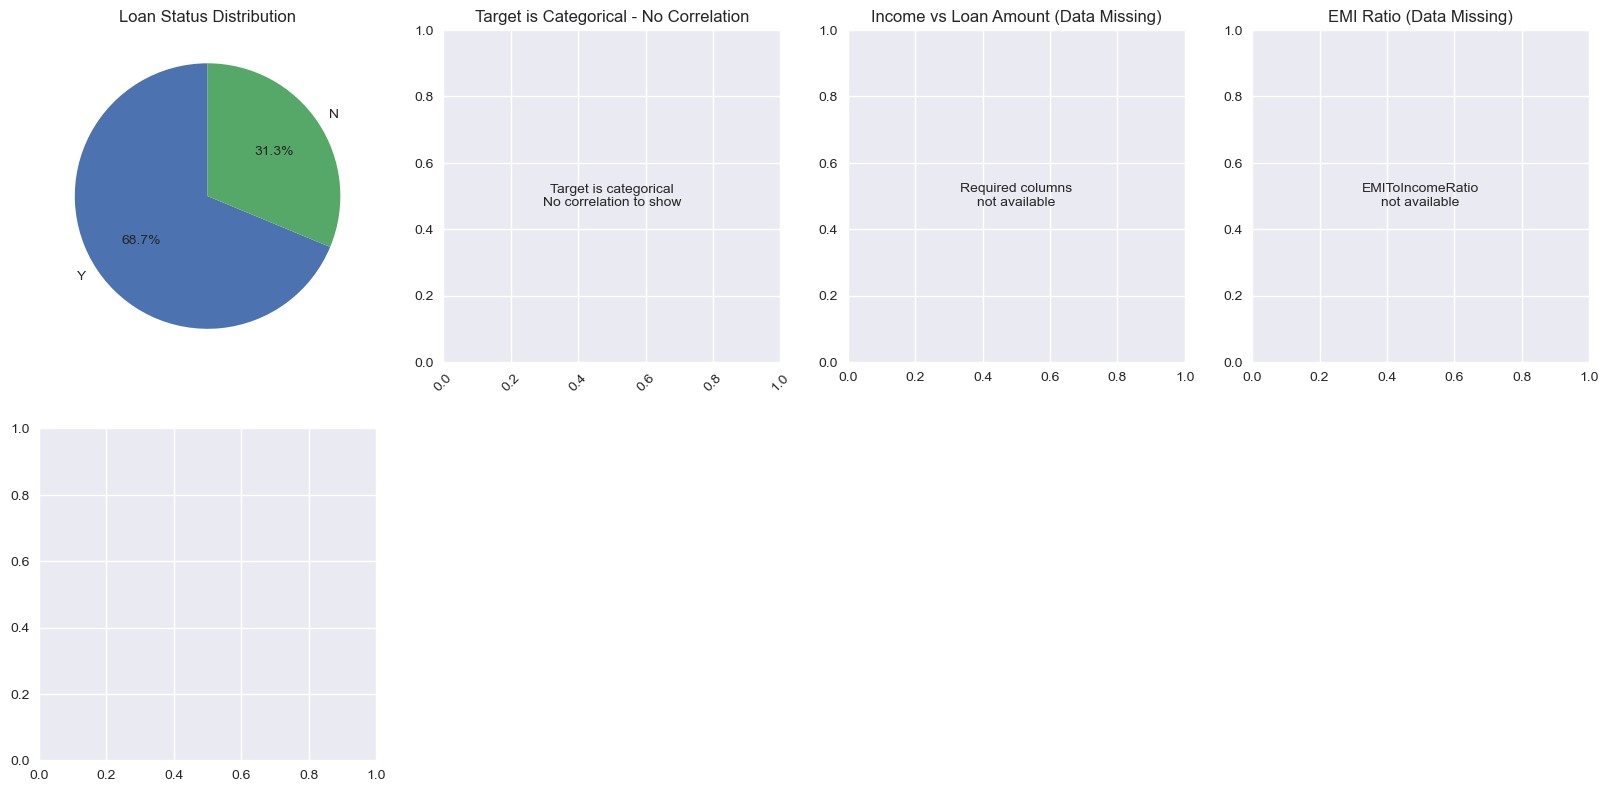

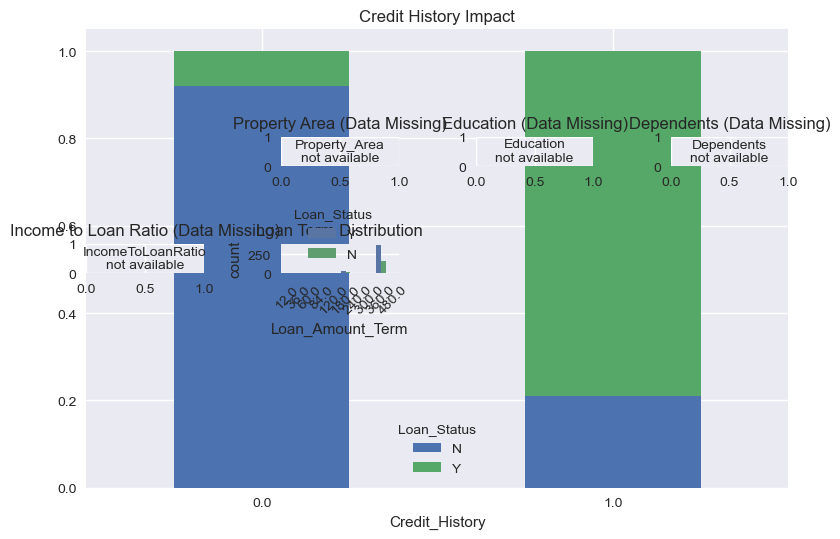


STATISTICAL SUMMARY
Dataset shape: (614, 17)
Target distribution:
Loan_Status
Y    422
N    192
Name: count, dtype: int64
Missing values:
ApplicantIncome            0
Married_Yes                0
Property_Area_Semiurban    0
Self_Employed_Yes          0
Education_Not Graduate     0
Dependents_3+              0
Dependents_2               0
Dependents_1               0
Gender_Male                0
CoapplicantIncome          0
LoanAmount_log             0
Total_Income               0
Loan_Status                0
Credit_History             0
Loan_Amount_Term           0
LoanAmount                 0
Property_Area_Urban        0
dtype: int64

Available columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']


In [13]:
def advanced_eda(df, target_col='Loan_Status'):
    """Comprehensive exploratory data analysis"""
    
    # Check if target column exists
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in DataFrame")
        print(f"Available columns: {list(df.columns)}")
        return
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 25))
    
    # 1. Target distribution
    plt.subplot(5, 4, 1)
    target_counts = df[target_col].value_counts()
    plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Loan Status Distribution')
    
    # 2. Correlation heatmap - handle both numeric and categorical target
    plt.subplot(5, 4, 2)
    numeric_df = df.select_dtypes(include=[np.number])
    
    # If target is categorical, create numeric version for correlation
    if target_col in numeric_df.columns:
        correlation_matrix = numeric_df.corr()
        target_corr = correlation_matrix[target_col].sort_values(ascending=False)
        # Remove target itself from correlation list
        target_corr = target_corr[target_corr.index != target_col]
        sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation with Target')
    else:
        # If target is not numeric, show message
        plt.text(0.5, 0.5, 'Target is categorical\nNo correlation to show', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Target is Categorical - No Correlation')
    
    plt.xticks(rotation=45)
    
    # 3. Income vs Loan Amount by Status - with error handling
    plt.subplot(5, 4, 3)
    if 'TotalIncome' in df.columns and 'LoanAmount' in df.columns:
        scatter = plt.scatter(df['TotalIncome'], df['LoanAmount'], 
                            c=pd.factorize(df[target_col])[0], alpha=0.6, cmap='viridis')
        plt.colorbar(scatter)
        plt.xlabel('Total Income')
        plt.ylabel('Loan Amount')
        plt.title('Income vs Loan Amount')
    else:
        plt.text(0.5, 0.5, 'Required columns\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Income vs Loan Amount (Data Missing)')
    
    # 4. EMI to Income Ratio distribution - with error handling
    plt.subplot(5, 4, 4)
    if 'EMIToIncomeRatio' in df.columns:
        sns.boxplot(x=target_col, y='EMIToIncomeRatio', data=df)
        plt.title('EMI to Income Ratio by Loan Status')
    else:
        plt.text(0.5, 0.5, 'EMIToIncomeRatio\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('EMI Ratio (Data Missing)')
    
    # 5. Credit History impact - with error handling
    plt.subplot(5, 4, 5)
    if 'Credit_History' in df.columns:
        pd.crosstab(df['Credit_History'], df[target_col], normalize='index').plot(kind='bar', stacked=True)
        plt.title('Credit History Impact')
        plt.xticks(rotation=0)
    else:
        plt.text(0.5, 0.5, 'Credit_History\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Credit History (Data Missing)')
    
    # 6. Property Area distribution - with error handling
    plt.subplot(5, 4, 6)
    if 'Property_Area' in df.columns:
        pd.crosstab(df['Property_Area'], df[target_col]).plot(kind='bar', stacked=True)
        plt.title('Property Area Distribution')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'Property_Area\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Property Area (Data Missing)')
    
    # 7. Education impact - with error handling
    plt.subplot(5, 4, 7)
    if 'Education' in df.columns:
        pd.crosstab(df['Education'], df[target_col], normalize='index').plot(kind='bar', stacked=True)
        plt.title('Education Impact')
        plt.xticks(rotation=0)
    else:
        plt.text(0.5, 0.5, 'Education\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Education (Data Missing)')
    
    # 8. Dependents distribution - with error handling
    plt.subplot(5, 4, 8)
    if 'Dependents' in df.columns:
        pd.crosstab(df['Dependents'], df[target_col]).plot(kind='bar', stacked=True)
        plt.title('Dependents Distribution')
        plt.xticks(rotation=0)
    else:
        plt.text(0.5, 0.5, 'Dependents\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Dependents (Data Missing)')
    
    # 9. Income to Loan Ratio - with error handling
    plt.subplot(5, 4, 9)
    if 'IncomeToLoanRatio' in df.columns:
        sns.histplot(data=df, x='IncomeToLoanRatio', hue=target_col, multiple="stack", kde=True)
        plt.title('Income to Loan Ratio Distribution')
    else:
        plt.text(0.5, 0.5, 'IncomeToLoanRatio\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Income to Loan Ratio (Data Missing)')
    
    # 10. Loan Amount Term - with error handling
    plt.subplot(5, 4, 10)
    if 'Loan_Amount_Term' in df.columns:
        sns.countplot(data=df, x='Loan_Amount_Term', hue=target_col)
        plt.title('Loan Term Distribution')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'Loan_Amount_Term\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Loan Term (Data Missing)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n" + "="*50)
    print("STATISTICAL SUMMARY")
    print("="*50)
    print(f"Dataset shape: {df.shape}")
    print(f"Target distribution:\n{df[target_col].value_counts()}")
    print(f"Missing values:\n{df.isnull().sum().sort_values(ascending=False)}")
    
    # Print available columns for debugging
    print(f"\nAvailable columns: {list(df.columns)}")

# First, let's check what columns are actually available
print("Available columns in train_processed:")
print(train_processed.columns.tolist())
print(f"\nDataFrame shape: {train_processed.shape}")

# Check if Loan_Status exists and its data type
if 'Loan_Status' in train_processed.columns:
    print(f"\nLoan_Status dtype: {train_processed['Loan_Status'].dtype}")
    print(f"Loan_Status unique values: {train_processed['Loan_Status'].unique()}")

# Now perform EDA
advanced_eda(train_processed)

In [14]:
# First, let's check what columns we have in the processed data
print("Columns in train_processed:")
print(train_processed.columns.tolist())
print("\nData types:")
print(train_processed.dtypes)

# Let's check if Loan_Status exists and its data type
if 'Loan_Status' in train_processed.columns:
    print(f"\nLoan_Status unique values: {train_processed['Loan_Status'].unique()}")
    print(f"Loan_Status value counts:\n{train_processed['Loan_Status'].value_counts()}")
else:
    print("\nLoan_Status column is missing from processed data!")

Columns in train_processed:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']

Data types:
ApplicantIncome            float64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                 object
Total_Income               float64
LoanAmount_log             float64
Gender_Male                   bool
Married_Yes                   bool
Dependents_1                  bool
Dependents_2                  bool
Dependents_3+                 bool
Education_Not Graduate        bool
Self_Employed_Yes             bool
Property_Area_Semiurban       bool
Property_Area_Urban           bool
dtype: object

Loan_Status unique values: ['Y'

In [15]:
class LoanDataPreprocessor:
    def __init__(self):
        self.numeric_imputer = SimpleImputer(strategy='median')
        self.categorical_imputer = SimpleImputer(strategy='most_frequent')
        self.scaler = StandardScaler()
        self.label_encoders = {}
        
    def preprocess(self, df, is_train=True):
        df_processed = df.copy()
        
        # Store Loan_ID for submission
        loan_ids = df_processed['Loan_ID'] if 'Loan_ID' in df_processed.columns else None
        
        # Handle Dependents column
        df_processed['Dependents'] = df_processed['Dependents'].replace('3+', '3')
        
        # Convert to appropriate data types
        numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
        categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                          'Self_Employed', 'Credit_History', 'Property_Area']
        
        for col in numeric_cols:
            if col in df_processed.columns:
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        
        # Advanced feature engineering
        df_processed = self._create_features(df_processed)
        
        # Handle missing values
        df_processed = self._handle_missing_values(df_processed, numeric_cols, categorical_cols, is_train)
        
        # Encode categorical variables
        df_processed = self._encode_categorical(df_processed, categorical_cols, is_train)
        
        # Scale numerical features (exclude target and ID columns)
        exclude_cols = ['Loan_ID', 'Loan_Status'] if is_train else ['Loan_ID']
        numerical_features = [col for col in df_processed.columns 
                           if col not in exclude_cols + categorical_cols 
                           and df_processed[col].dtype in ['int64', 'float64']]
        
        if len(numerical_features) > 0:
            if is_train:
                df_processed[numerical_features] = self.scaler.fit_transform(df_processed[numerical_features])
            else:
                df_processed[numerical_features] = self.scaler.transform(df_processed[numerical_features])
        
        return df_processed.drop('Loan_ID', axis=1) if 'Loan_ID' in df_processed.columns else df_processed
    
    def _create_features(self, df):
        """Create advanced features for better prediction"""
        # Total income
        df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
        
        # Income to loan ratio
        df['IncomeToLoanRatio'] = df['TotalIncome'] / (df['LoanAmount'] + 1)
        
        # EMI (assuming 8.5% interest rate)
        df['EMI'] = df['LoanAmount'] * 0.0085 * (1 + 0.0085)**df['Loan_Amount_Term'] / ((1 + 0.0085)**df['Loan_Amount_Term'] - 1 + 1e-8)
        
        # EMI to income ratio
        df['EMIToIncomeRatio'] = df['EMI'] / (df['TotalIncome'] + 1)
        
        # Loan amount to income ratio
        df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['TotalIncome'] + 1)
        
        # Has co-applicant
        df['HasCoapplicant'] = (df['CoapplicantIncome'] > 0).astype(int)
        
        # Income stability score (higher is better)
        df['IncomeStability'] = df['ApplicantIncome'] / (df['CoapplicantIncome'] + 1)
        
        # Log transformations for skewed features
        df['LogApplicantIncome'] = np.log1p(df['ApplicantIncome'])
        df['LogLoanAmount'] = np.log1p(df['LoanAmount'])
        df['LogTotalIncome'] = np.log1p(df['TotalIncome'])
        
        return df
    
    def _handle_missing_values(self, df, numeric_cols, categorical_cols, is_train):
        """Handle missing values with appropriate strategies"""
        
        # Handle numerical missing values
        numerical_missing = [col for col in numeric_cols if col in df.columns and df[col].isnull().any()]
        if numerical_missing:
            if is_train:
                df[numerical_missing] = self.numeric_imputer.fit_transform(df[numerical_missing])
            else:
                df[numerical_missing] = self.numeric_imputer.transform(df[numerical_missing])
        
        # Handle categorical missing values
        categorical_missing = [col for col in categorical_cols if col in df.columns and df[col].isnull().any()]
        if categorical_missing:
            if is_train:
                df[categorical_missing] = self.categorical_imputer.fit_transform(df[categorical_missing])
            else:
                df[categorical_missing] = self.categorical_imputer.transform(df[categorical_missing])
        
        return df
    
    def _encode_categorical(self, df, categorical_cols, is_train):
        """Encode categorical variables"""
        for col in categorical_cols:
            if col in df.columns:
                if is_train:
                    le = LabelEncoder()
                    df[col] = le.fit_transform(df[col].astype(str))
                    self.label_encoders[col] = le
                else:
                    le = self.label_encoders.get(col)
                    if le is not None:
                        # Handle unseen categories in test set
                        unseen_mask = ~df[col].astype(str).isin(le.classes_)
                        if unseen_mask.any():
                            df.loc[unseen_mask, col] = le.classes_[0]  # Use most frequent category
                        df[col] = le.transform(df[col].astype(str))
        return df

# Reinitialize and process data
preprocessor = LoanDataPreprocessor()
train_processed = preprocessor.preprocess(train_df, is_train=True)
test_processed = preprocessor.preprocess(test_df, is_train=False)

print("Processed training data shape:", train_processed.shape)
print("Processed test data shape:", test_processed.shape)
print("\nColumns in train_processed:")
print(train_processed.columns.tolist())

Processed training data shape: (614, 24)
Processed test data shape: (367, 23)

Columns in train_processed:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'TotalIncome', 'IncomeToLoanRatio', 'EMI', 'EMIToIncomeRatio', 'LoanToIncomeRatio', 'HasCoapplicant', 'IncomeStability', 'LogApplicantIncome', 'LogLoanAmount', 'LogTotalIncome']


Current data status:
Train processed shape: (614, 24)
Test processed shape: (367, 23)

Train columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'TotalIncome', 'IncomeToLoanRatio', 'EMI', 'EMIToIncomeRatio', 'LoanToIncomeRatio', 'HasCoapplicant', 'IncomeStability', 'LogApplicantIncome', 'LogLoanAmount', 'LogTotalIncome']

Loan_Status dtype: object
Loan_Status unique values: ['Y' 'N']

Converting Loan_Status to numeric...

After conversion - Loan_Status dtype: int32
Loan_Status unique values: [1 0]
Loan_Status distribution:
Loan_Status
0    192
1    422
Name: count, dtype: int64

Performing Enhanced EDA...


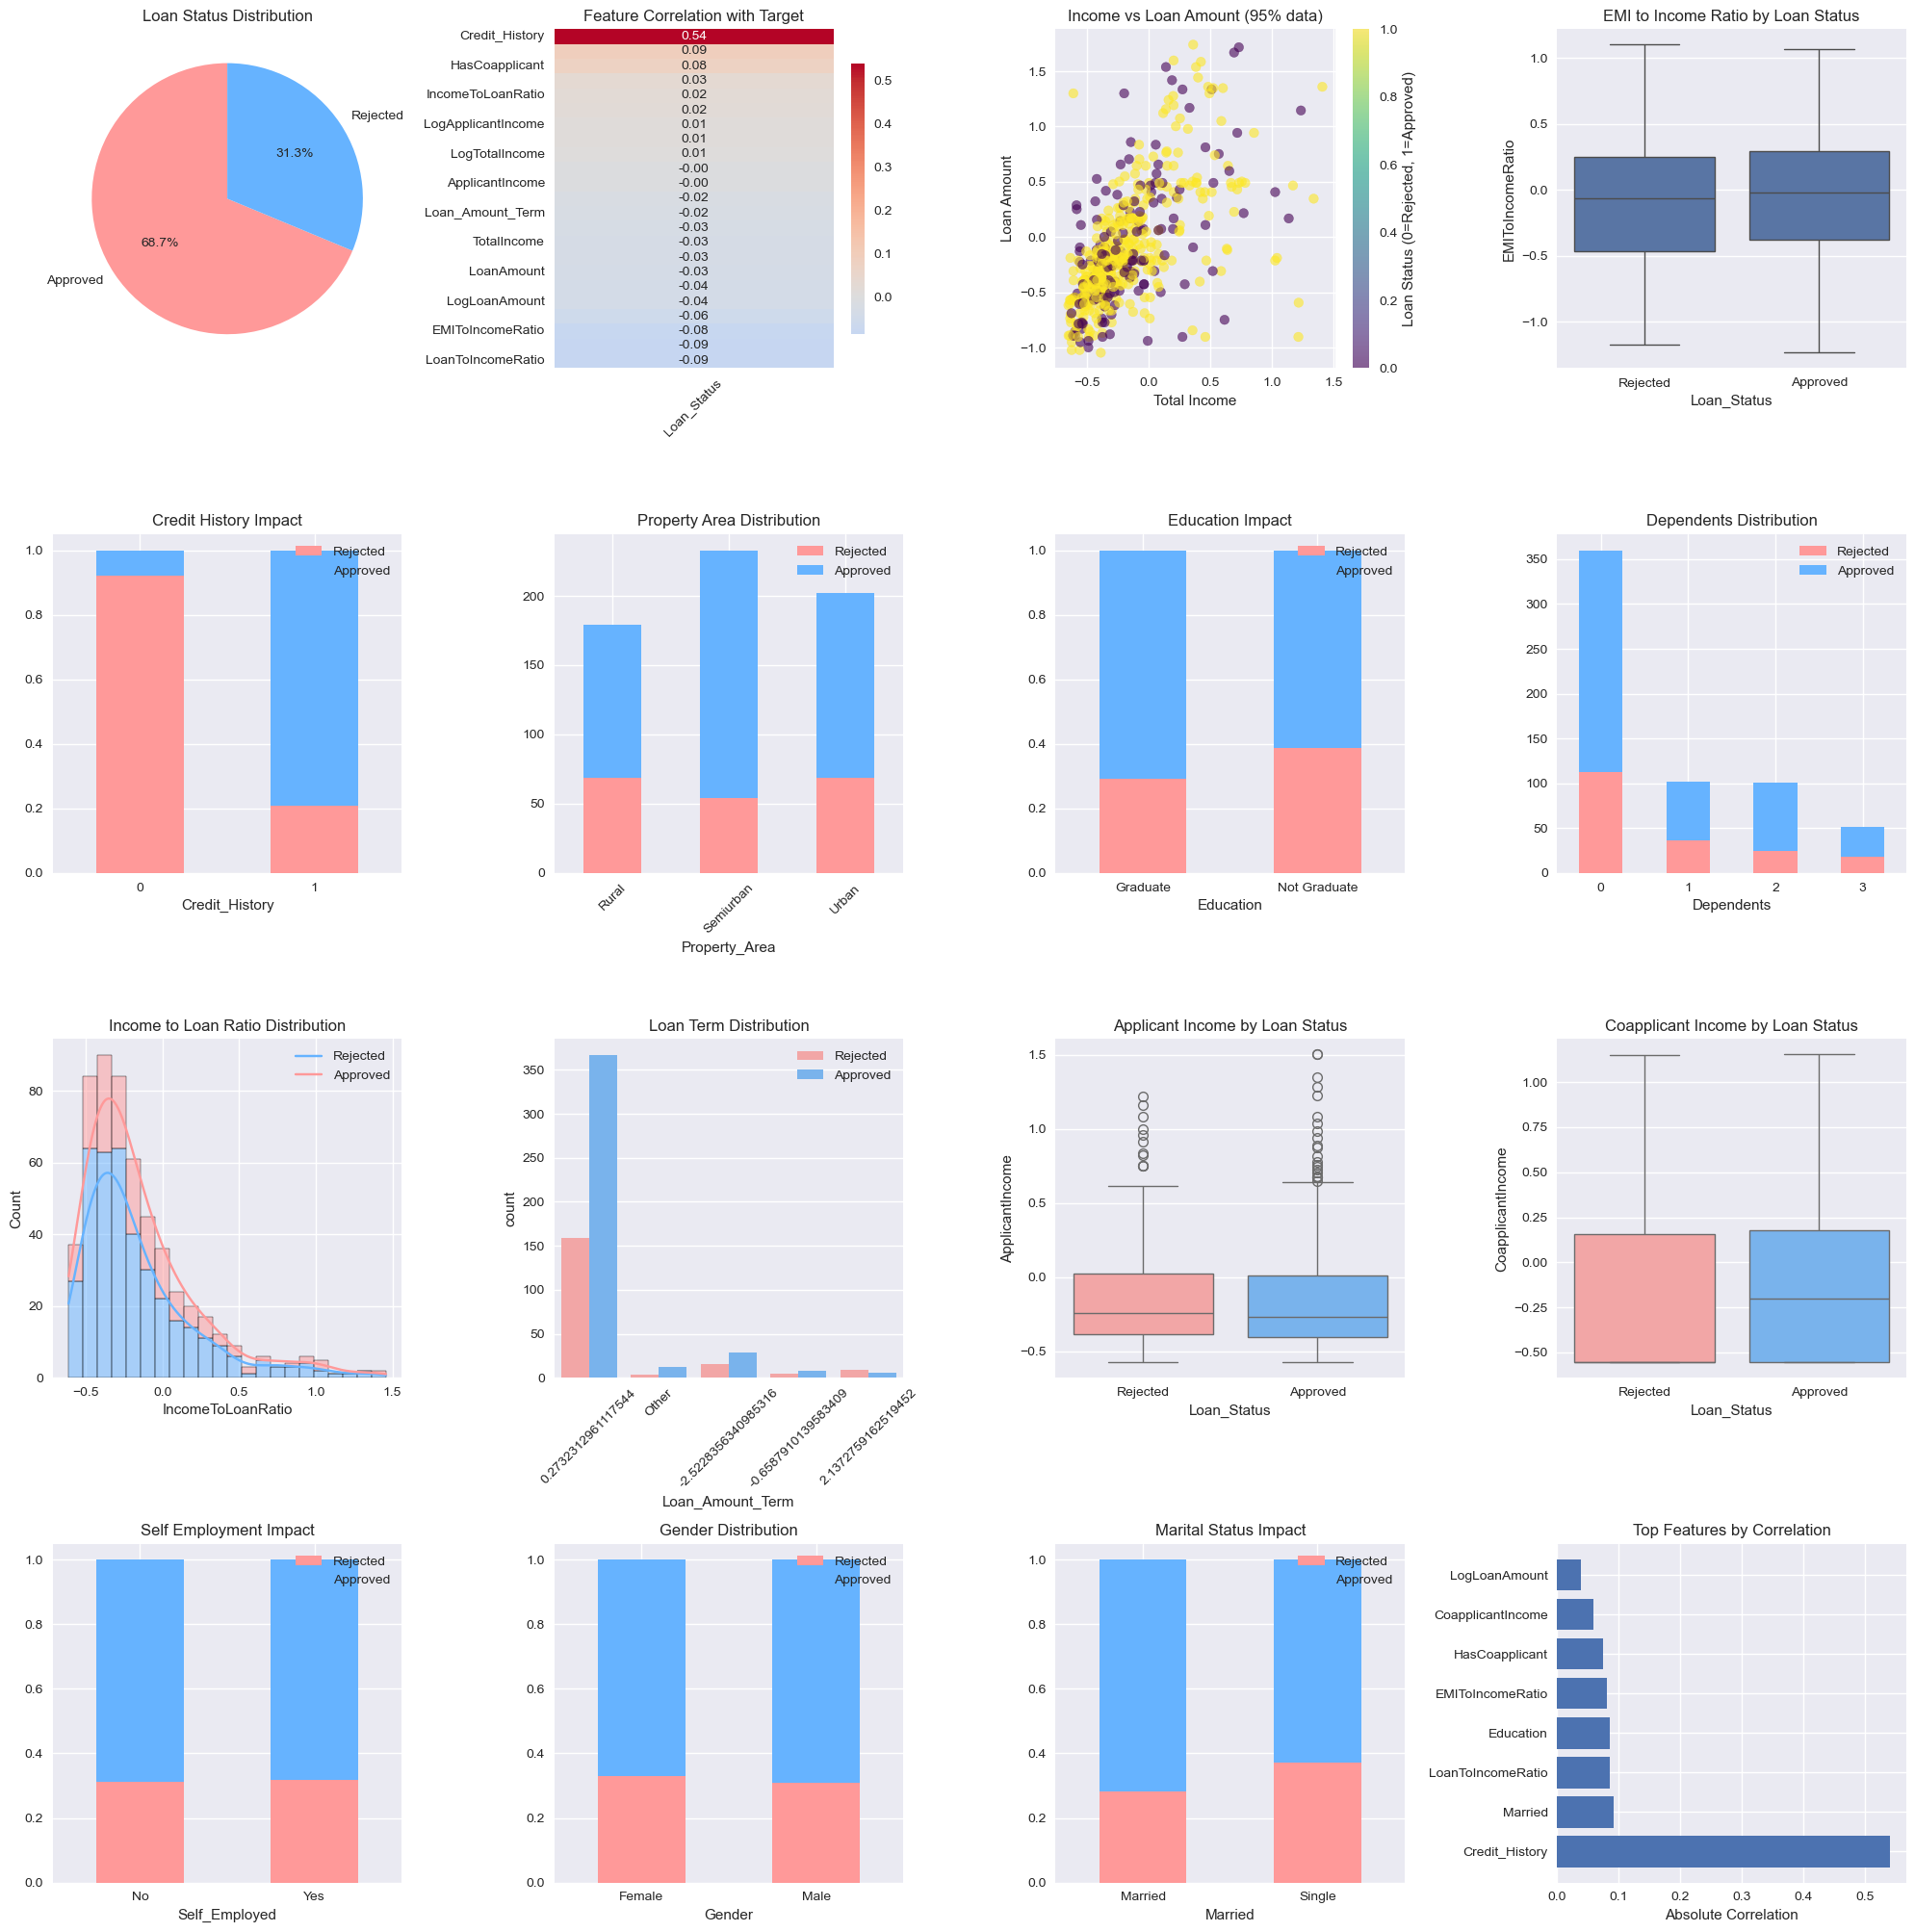


STATISTICAL SUMMARY
Dataset shape: (614, 24)

Target distribution:
Loan_Status
0    192
1    422
Name: count, dtype: int64

Target proportion:
Loan_Status
0    0.312704
1    0.687296
Name: proportion, dtype: float64

No missing values in the dataset!

KEY INSIGHTS

Credit History Approval Rate:
  Bad Credit History: 7.9% approval
  Good Credit History: 79.0% approval

Property Area Approval Rate:
  Rural: 61.5% approval
  Semiurban: 76.8% approval
  Urban: 65.8% approval

Median Total Income:
  Approved: -0
  Rejected: -0


In [16]:
def enhanced_eda(df, target_col='Loan_Status'):
    """Comprehensive exploratory data analysis for processed loan data"""
    
    # Check if target column exists
    if target_col not in df.columns:
        print(f"Warning: Target column '{target_col}' not found in dataframe!")
        print("Available columns:", df.columns.tolist())
        return
    
    # Create a copy to avoid modifying original data
    df_eda = df.copy()
    
    # Convert target to numeric if it's string
    if df_eda[target_col].dtype == 'object':
        print("Converting target column from string to numeric...")
        df_eda[target_col] = df_eda[target_col].map({'Y': 1, 'N': 0, 'Yes': 1, 'No': 0})
        # Handle any remaining non-numeric values
        df_eda[target_col] = pd.to_numeric(df_eda[target_col], errors='coerce')
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 25))
    
    # 1. Target distribution
    plt.subplot(5, 4, 1)
    target_counts = df_eda[target_col].value_counts()
    labels = ['Rejected' if x == 0 else 'Approved' for x in target_counts.index]
    colors = ['#ff9999', '#66b3ff']
    plt.pie(target_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Loan Status Distribution')
    
    # 2. Correlation heatmap
    plt.subplot(5, 4, 2)
    numeric_df = df_eda.select_dtypes(include=[np.number])
    if target_col in numeric_df.columns:
        correlation_matrix = numeric_df.corr()
        target_corr = correlation_matrix[target_col].sort_values(ascending=False)
        # Remove target itself from correlation
        target_corr = target_corr[target_corr.index != target_col]
        if len(target_corr) > 0:
            sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', center=0,
                       fmt='.2f', cbar_kws={'shrink': 0.8})
            plt.title('Feature Correlation with Target')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'No numeric features\nfor correlation', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Correlation Analysis')
    else:
        plt.text(0.5, 0.5, 'Target not numeric\nfor correlation', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Correlation Analysis')
    
    # 3. Income vs Loan Amount by Status
    plt.subplot(5, 4, 3)
    if 'TotalIncome' in df_eda.columns and 'LoanAmount' in df_eda.columns:
        # Filter out extreme outliers for better visualization
        temp_df = df_eda[['TotalIncome', 'LoanAmount', target_col]].copy()
        Q1_income = temp_df['TotalIncome'].quantile(0.05)
        Q3_income = temp_df['TotalIncome'].quantile(0.95)
        Q1_loan = temp_df['LoanAmount'].quantile(0.05)
        Q3_loan = temp_df['LoanAmount'].quantile(0.95)
        
        temp_df = temp_df[
            (temp_df['TotalIncome'] >= Q1_income) & 
            (temp_df['TotalIncome'] <= Q3_income) &
            (temp_df['LoanAmount'] >= Q1_loan) & 
            (temp_df['LoanAmount'] <= Q3_loan)
        ]
        
        scatter = plt.scatter(temp_df['TotalIncome'], temp_df['LoanAmount'], 
                            c=temp_df[target_col], alpha=0.6, cmap='viridis')
        plt.colorbar(scatter, label='Loan Status (0=Rejected, 1=Approved)')
        plt.xlabel('Total Income')
        plt.ylabel('Loan Amount')
        plt.title('Income vs Loan Amount (95% data)')
    else:
        plt.text(0.5, 0.5, 'Income/Loan features\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Income vs Loan Amount')
    
    # 4. EMI to Income Ratio distribution
    plt.subplot(5, 4, 4)
    if 'EMIToIncomeRatio' in df_eda.columns:
        # Remove outliers for better visualization
        temp_df = df_eda[['EMIToIncomeRatio', target_col]].copy()
        Q1 = temp_df['EMIToIncomeRatio'].quantile(0.05)
        Q3 = temp_df['EMIToIncomeRatio'].quantile(0.95)
        temp_df = temp_df[(temp_df['EMIToIncomeRatio'] >= Q1) & (temp_df['EMIToIncomeRatio'] <= Q3)]
        
        sns.boxplot(x=target_col, y='EMIToIncomeRatio', data=temp_df)
        plt.xticks([0, 1], ['Rejected', 'Approved'])
        plt.title('EMI to Income Ratio by Loan Status')
    else:
        plt.text(0.5, 0.5, 'EMI Ratio feature\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('EMI to Income Ratio')
    
    # 5. Credit History impact
    plt.subplot(5, 4, 5)
    if 'Credit_History' in df_eda.columns:
        credit_cross = pd.crosstab(df_eda['Credit_History'], df_eda[target_col], normalize='index')
        credit_cross.columns = ['Rejected', 'Approved']
        credit_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Credit History Impact')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Credit History\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Credit History Impact')
    
    # 6. Property Area distribution
    plt.subplot(5, 4, 6)
    if 'Property_Area' in df_eda.columns:
        # Map numeric codes back to readable labels if needed
        area_mapping = {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}
        area_series = df_eda['Property_Area'].map(area_mapping).fillna(df_eda['Property_Area'])
        
        area_cross = pd.crosstab(area_series, df_eda[target_col])
        area_cross.columns = ['Rejected', 'Approved']
        area_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Property Area Distribution')
        plt.xticks(rotation=45)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Property Area\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Property Area Distribution')
    
    # 7. Education impact
    plt.subplot(5, 4, 7)
    if 'Education' in df_eda.columns:
        # Map numeric codes to readable labels
        edu_mapping = {0: 'Graduate', 1: 'Not Graduate'}
        edu_series = df_eda['Education'].map(edu_mapping).fillna(df_eda['Education'])
        
        edu_cross = pd.crosstab(edu_series, df_eda[target_col], normalize='index')
        edu_cross.columns = ['Rejected', 'Approved']
        edu_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Education Impact')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Education data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Education Impact')
    
    # 8. Dependents distribution
    plt.subplot(5, 4, 8)
    if 'Dependents' in df_eda.columns:
        dep_cross = pd.crosstab(df_eda['Dependents'], df_eda[target_col])
        dep_cross.columns = ['Rejected', 'Approved']
        dep_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Dependents Distribution')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Dependents data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Dependents Distribution')
    
    # 9. Income to Loan Ratio
    plt.subplot(5, 4, 9)
    if 'IncomeToLoanRatio' in df_eda.columns:
        # Remove outliers for better visualization
        temp_df = df_eda[['IncomeToLoanRatio', target_col]].copy()
        Q1 = temp_df['IncomeToLoanRatio'].quantile(0.05)
        Q3 = temp_df['IncomeToLoanRatio'].quantile(0.95)
        temp_df = temp_df[(temp_df['IncomeToLoanRatio'] >= Q1) & (temp_df['IncomeToLoanRatio'] <= Q3)]
        
        sns.histplot(data=temp_df, x='IncomeToLoanRatio', hue=target_col, 
                    multiple="stack", kde=True, palette=['#ff9999', '#66b3ff'])
        plt.title('Income to Loan Ratio Distribution')
        plt.legend(['Rejected', 'Approved'])
    else:
        plt.text(0.5, 0.5, 'Income to Loan Ratio\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Income to Loan Ratio')
    
    # 10. Loan Amount Term
    plt.subplot(5, 4, 10)
    if 'Loan_Amount_Term' in df_eda.columns:
        # Group less frequent terms
        term_counts = df_eda['Loan_Amount_Term'].value_counts()
        common_terms = term_counts[term_counts > 10].index
        term_series = df_eda['Loan_Amount_Term'].apply(
            lambda x: x if x in common_terms else 'Other'
        )
        
        temp_df = pd.DataFrame({
            'Loan_Amount_Term': term_series,
            target_col: df_eda[target_col]
        })
        
        sns.countplot(data=temp_df, x='Loan_Amount_Term', hue=target_col, 
                     palette=['#ff9999', '#66b3ff'])
        plt.title('Loan Term Distribution')
        plt.xticks(rotation=45)
        plt.legend(['Rejected', 'Approved'])
    else:
        plt.text(0.5, 0.5, 'Loan Term data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Loan Term Distribution')
    
    # 11. Applicant Income distribution
    plt.subplot(5, 4, 11)
    if 'ApplicantIncome' in df_eda.columns:
        # Remove outliers
        temp_df = df_eda[['ApplicantIncome', target_col]].copy()
        Q1 = temp_df['ApplicantIncome'].quantile(0.05)
        Q3 = temp_df['ApplicantIncome'].quantile(0.95)
        temp_df = temp_df[(temp_df['ApplicantIncome'] >= Q1) & (temp_df['ApplicantIncome'] <= Q3)]
        
        sns.boxplot(x=target_col, y='ApplicantIncome', data=temp_df, palette=['#ff9999', '#66b3ff'])
        plt.xticks([0, 1], ['Rejected', 'Approved'])
        plt.title('Applicant Income by Loan Status')
    else:
        plt.text(0.5, 0.5, 'Applicant Income\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Applicant Income')
    
    # 12. Coapplicant Income distribution
    plt.subplot(5, 4, 12)
    if 'CoapplicantIncome' in df_eda.columns:
        # Remove outliers
        temp_df = df_eda[['CoapplicantIncome', target_col]].copy()
        Q1 = temp_df['CoapplicantIncome'].quantile(0.05)
        Q3 = temp_df['CoapplicantIncome'].quantile(0.95)
        temp_df = temp_df[(temp_df['CoapplicantIncome'] >= Q1) & (temp_df['CoapplicantIncome'] <= Q3)]
        
        sns.boxplot(x=target_col, y='CoapplicantIncome', data=temp_df, palette=['#ff9999', '#66b3ff'])
        plt.xticks([0, 1], ['Rejected', 'Approved'])
        plt.title('Coapplicant Income by Loan Status')
    else:
        plt.text(0.5, 0.5, 'Coapplicant Income\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Coapplicant Income')
    
    # 13. Self Employed distribution
    plt.subplot(5, 4, 13)
    if 'Self_Employed' in df_eda.columns:
        self_emp_mapping = {0: 'No', 1: 'Yes'}
        self_emp_series = df_eda['Self_Employed'].map(self_emp_mapping).fillna(df_eda['Self_Employed'])
        
        self_emp_cross = pd.crosstab(self_emp_series, df_eda[target_col], normalize='index')
        self_emp_cross.columns = ['Rejected', 'Approved']
        self_emp_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Self Employment Impact')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Self Employment data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Self Employment Impact')
    
    # 14. Gender distribution
    plt.subplot(5, 4, 14)
    if 'Gender' in df_eda.columns:
        gender_mapping = {0: 'Female', 1: 'Male'}
        gender_series = df_eda['Gender'].map(gender_mapping).fillna(df_eda['Gender'])
        
        gender_cross = pd.crosstab(gender_series, df_eda[target_col], normalize='index')
        gender_cross.columns = ['Rejected', 'Approved']
        gender_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Gender Distribution')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Gender data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Gender Distribution')
    
    # 15. Married status distribution
    plt.subplot(5, 4, 15)
    if 'Married' in df_eda.columns:
        married_mapping = {0: 'Single', 1: 'Married'}
        married_series = df_eda['Married'].map(married_mapping).fillna(df_eda['Married'])
        
        married_cross = pd.crosstab(married_series, df_eda[target_col], normalize='index')
        married_cross.columns = ['Rejected', 'Approved']
        married_cross.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#ff9999', '#66b3ff'])
        plt.title('Marital Status Impact')
        plt.xticks(rotation=0)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Marital Status data\nnot available', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Marital Status Impact')
    
    # 16. Feature importance preview
    plt.subplot(5, 4, 16)
    if target_col in numeric_df.columns:
        # Calculate absolute correlation with target
        correlations = numeric_df.corr()[target_col].abs().sort_values(ascending=False)
        correlations = correlations[correlations.index != target_col]  # Remove target itself
        top_correlations = correlations.head(8)  # Top 8 features
        
        if len(top_correlations) > 0:
            plt.barh(range(len(top_correlations)), top_correlations.values)
            plt.yticks(range(len(top_correlations)), top_correlations.index)
            plt.xlabel('Absolute Correlation')
            plt.title('Top Features by Correlation')
        else:
            plt.text(0.5, 0.5, 'No strong correlations\nfound', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Feature Correlations')
    else:
        plt.text(0.5, 0.5, 'Target not numeric\nfor correlation', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY")
    print("="*60)
    print(f"Dataset shape: {df_eda.shape}")
    print(f"\nTarget distribution:")
    print(df_eda[target_col].value_counts().sort_index())
    print(f"\nTarget proportion:")
    print(df_eda[target_col].value_counts(normalize=True).sort_index())
    
    # Check for missing values
    missing_values = df_eda.isnull().sum()
    if missing_values.sum() > 0:
        print(f"\nMissing values:")
        print(missing_values[missing_values > 0].sort_values(ascending=False))
    else:
        print("\nNo missing values in the dataset!")
    
    # Key insights
    print("\n" + "="*60)
    print("KEY INSIGHTS")
    print("="*60)
    
    if 'Credit_History' in df_eda.columns:
        credit_approval = df_eda.groupby('Credit_History')[target_col].mean()
        print(f"\nCredit History Approval Rate:")
        for credit_val, approval_rate in credit_approval.items():
            status = "Good" if credit_val == 1 else "Bad"
            print(f"  {status} Credit History: {approval_rate:.1%} approval")
    
    if 'Property_Area' in df_eda.columns:
        area_approval = df_eda.groupby('Property_Area')[target_col].mean()
        print(f"\nProperty Area Approval Rate:")
        area_mapping = {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}
        for area_val, approval_rate in area_approval.items():
            area_name = area_mapping.get(area_val, area_val)
            print(f"  {area_name}: {approval_rate:.1%} approval")
    
    if 'TotalIncome' in df_eda.columns:
        approved_income = df_eda[df_eda[target_col] == 1]['TotalIncome'].median()
        rejected_income = df_eda[df_eda[target_col] == 0]['TotalIncome'].median()
        print(f"\nMedian Total Income:")
        print(f"  Approved: {approved_income:,.0f}")
        print(f"  Rejected: {rejected_income:,.0f}")

# Let's first check the current state of our data
print("Current data status:")
print(f"Train processed shape: {train_processed.shape}")
print(f"Test processed shape: {test_processed.shape}")
print(f"\nTrain columns: {train_processed.columns.tolist()}")
print(f"\nLoan_Status dtype: {train_processed['Loan_Status'].dtype}")
print(f"Loan_Status unique values: {train_processed['Loan_Status'].unique()}")

# Convert Loan_Status to numeric if needed
if train_processed['Loan_Status'].dtype == 'object':
    print("\nConverting Loan_Status to numeric...")
    train_processed['Loan_Status'] = train_processed['Loan_Status'].map({'Y': 1, 'N': 0})
    # Fill any NaN values with 0 (rejected)
    train_processed['Loan_Status'] = train_processed['Loan_Status'].fillna(0).astype(int)

print(f"\nAfter conversion - Loan_Status dtype: {train_processed['Loan_Status'].dtype}")
print(f"Loan_Status unique values: {train_processed['Loan_Status'].unique()}")
print(f"Loan_Status distribution:\n{train_processed['Loan_Status'].value_counts().sort_index()}")

# Now perform the enhanced EDA
print("\nPerforming Enhanced EDA...")
enhanced_eda(train_processed)


ENGINEERED FEATURES ANALYSIS


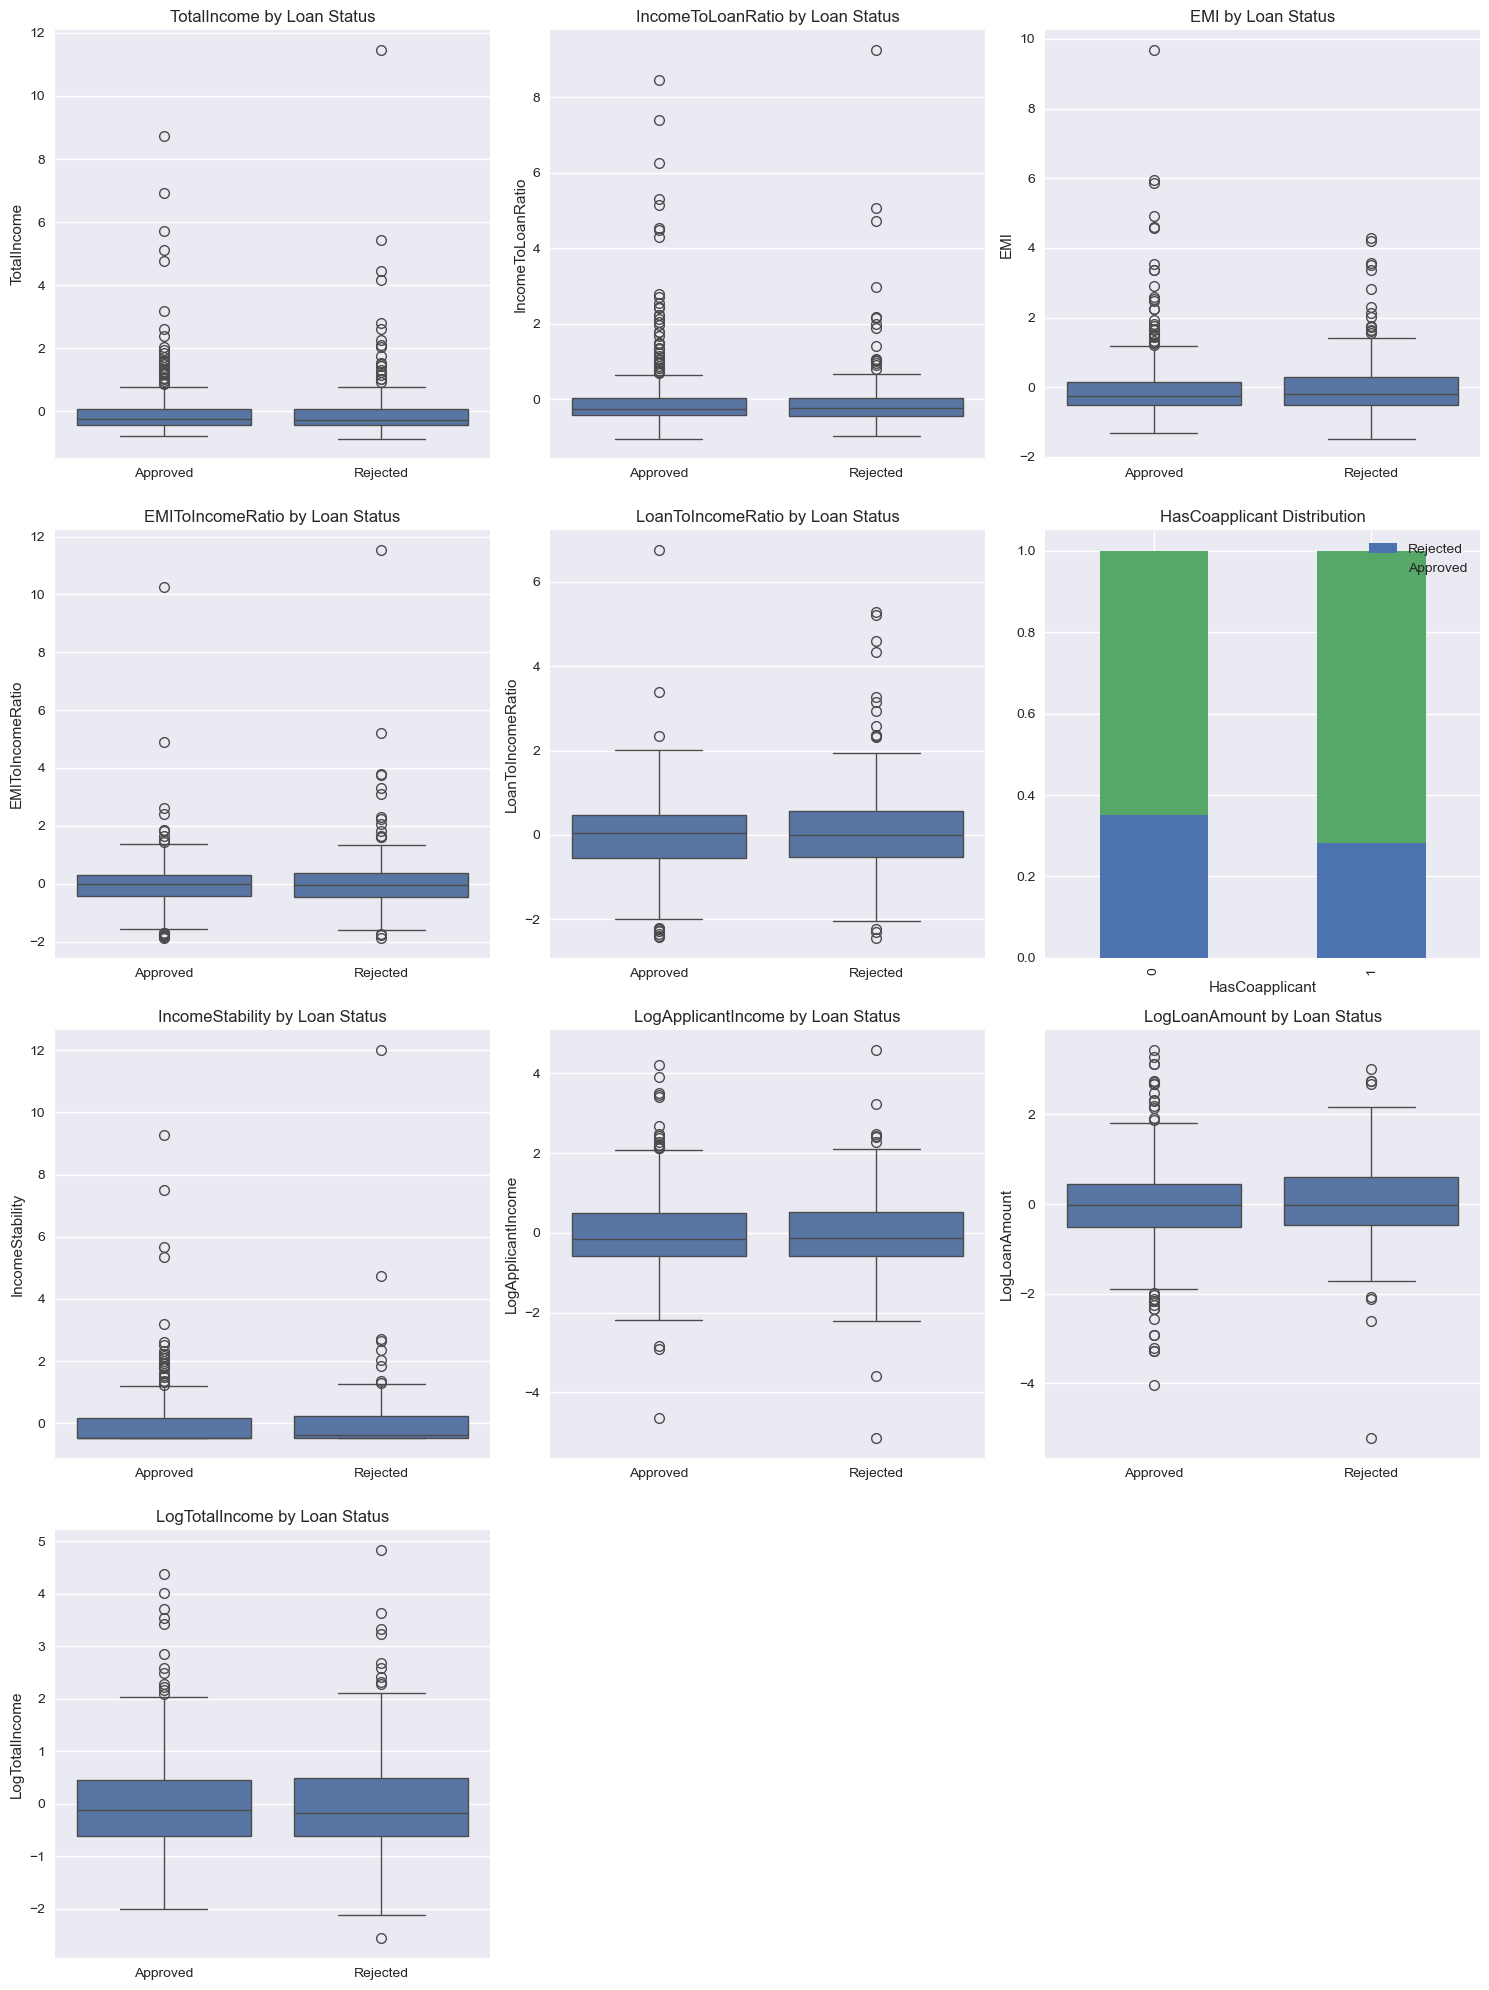


Engineered Features - Mean by Loan Status:
TotalIncome          | Rejected:     0.05 | Approved:    -0.02
IncomeToLoanRatio    | Rejected:    -0.04 | Approved:     0.02
EMI                  | Rejected:     0.04 | Approved:    -0.02
EMIToIncomeRatio     | Rejected:     0.12 | Approved:    -0.05
LoanToIncomeRatio    | Rejected:     0.13 | Approved:    -0.06
IncomeStability      | Rejected:     0.03 | Approved:    -0.01
LogApplicantIncome   | Rejected:    -0.02 | Approved:     0.01
LogLoanAmount        | Rejected:     0.06 | Approved:    -0.03
LogTotalIncome       | Rejected:    -0.01 | Approved:     0.00


In [17]:
def analyze_engineered_features(df, target_col='Loan_Status'):
    """Analyze the impact of engineered features"""
    if target_col not in df.columns:
        return
    
    engineered_features = ['TotalIncome', 'IncomeToLoanRatio', 'EMI', 'EMIToIncomeRatio', 
                         'LoanToIncomeRatio', 'HasCoapplicant', 'IncomeStability',
                         'LogApplicantIncome', 'LogLoanAmount', 'LogTotalIncome']
    
    available_engineered = [feat for feat in engineered_features if feat in df.columns]
    
    if available_engineered:
        print("\n" + "="*60)
        print("ENGINEERED FEATURES ANALYSIS")
        print("="*60)
        
        # Create subplots for engineered features
        n_features = len(available_engineered)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_features > 1 else [axes]
        
        for i, feature in enumerate(available_engineered[:len(axes)]):
            if df[feature].dtype in ['int64', 'float64']:
                # Boxplot for numerical features
                df_box = df[[feature, target_col]].copy()
                df_box[target_col] = df_box[target_col].map({0: 'Rejected', 1: 'Approved'})
                sns.boxplot(data=df_box, x=target_col, y=feature, ax=axes[i])
                axes[i].set_title(f'{feature} by Loan Status')
                axes[i].set_xlabel('')
            else:
                # Bar plot for categorical features
                cross_tab = pd.crosstab(df[feature], df[target_col], normalize='index')
                cross_tab.plot(kind='bar', stacked=True, ax=axes[i])
                axes[i].set_title(f'{feature} Distribution')
                axes[i].legend(['Rejected', 'Approved'])
        
        # Hide empty subplots
        for i in range(len(available_engineered), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical significance of engineered features
        print("\nEngineered Features - Mean by Loan Status:")
        for feature in available_engineered:
            if df[feature].dtype in ['int64', 'float64']:
                means = df.groupby(target_col)[feature].mean()
                print(f"{feature:20} | Rejected: {means[0]:8.2f} | Approved: {means[1]:8.2f}")

# Analyze engineered features
analyze_engineered_features(train_processed)

Final check of processed data:
Train shape: (614, 24)
Test shape: (367, 23)
Train columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Total_Income', 'LoanAmount_log', 'TotalIncome', 'IncomeToLoanRatio', 'EMI', 'EMIToIncomeRatio', 'LoanToIncomeRatio', 'HasCoapplicant', 'IncomeStability', 'LogApplicantIncome', 'LogLoanAmount', 'LogTotalIncome']
Loan_Status in train: True

Loan_Status values: [1 0]
Loan_Status distribution:
Loan_Status
1    422
0    192
Name: count, dtype: int64
ENHANCED EXPLORATORY DATA ANALYSIS
Dataset Shape: (614, 24)
Memory Usage: 0.09 MB

DATA TYPES
Gender                  int32
Married                 int32
Dependents              int32
Education               int32
Self_Employed           int32
ApplicantIncome       float64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_

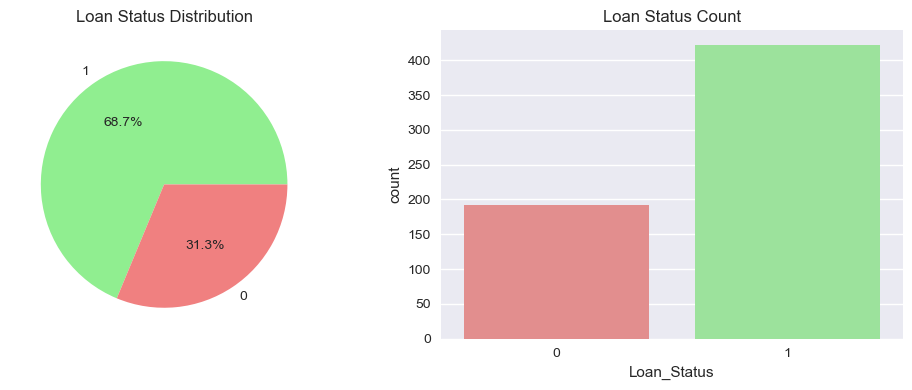


NUMERICAL FEATURES SUMMARY
           Gender     Married  Dependents   Education  Self_Employed  \
count  614.000000  614.000000  614.000000  614.000000     614.000000   
mean     0.817590    0.653094    0.744300    0.218241       0.133550   
std      0.386497    0.476373    1.009623    0.413389       0.340446   
min      0.000000    0.000000    0.000000    0.000000       0.000000   
25%      1.000000    0.000000    0.000000    0.000000       0.000000   
50%      1.000000    1.000000    0.000000    0.000000       0.000000   
75%      1.000000    1.000000    1.000000    0.000000       0.000000   
max      1.000000    1.000000    3.000000    1.000000       1.000000   

       ApplicantIncome  CoapplicantIncome    LoanAmount  Loan_Amount_Term  \
count     6.140000e+02       6.140000e+02  6.140000e+02      6.140000e+02   
mean     -4.339634e-18       4.050325e-17 -2.603780e-17      5.930833e-17   
std       1.000815e+00       1.000815e+00  1.000815e+00      1.000815e+00   
min      -8.606

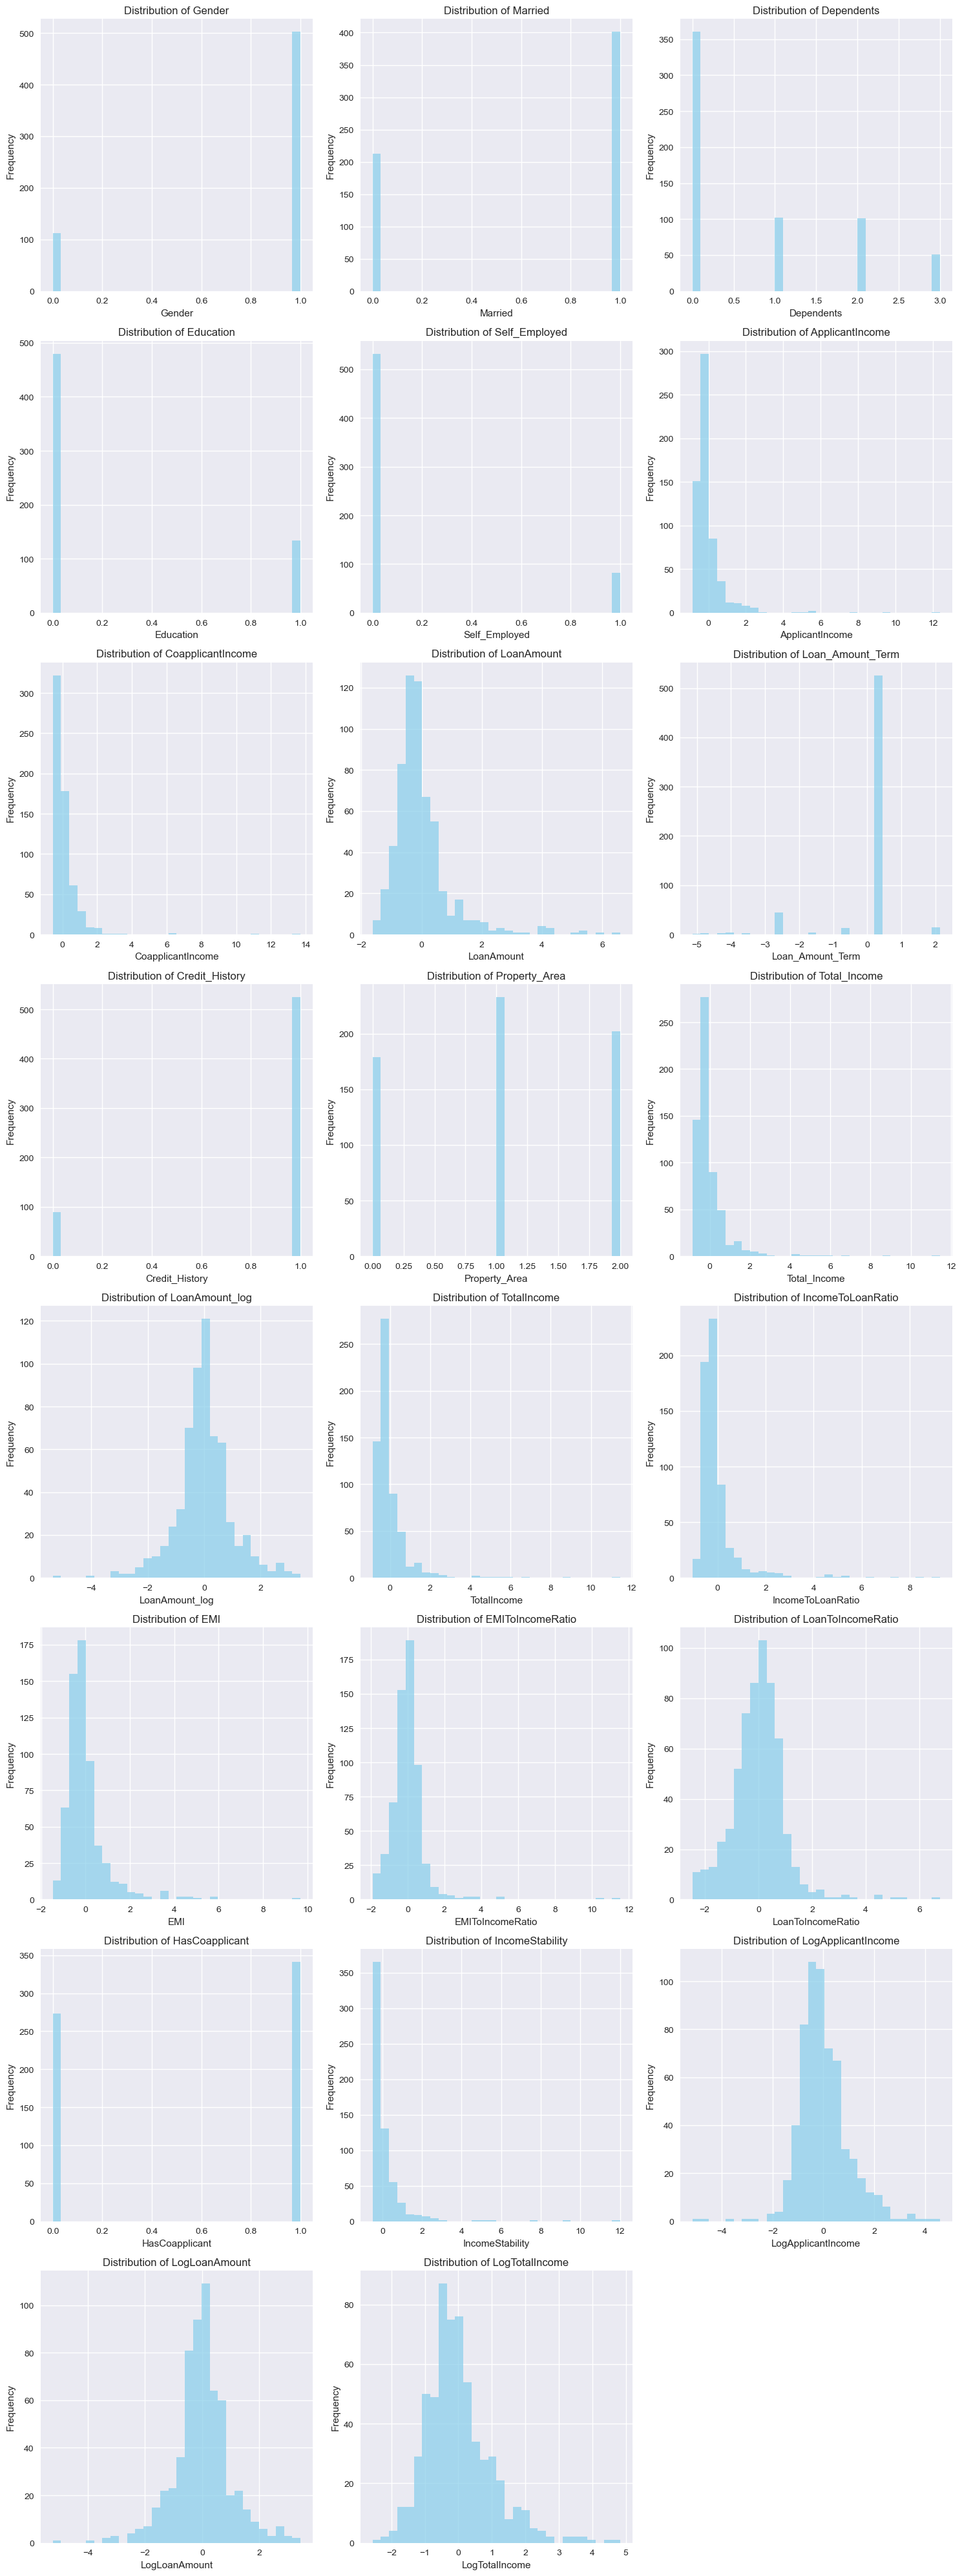


CORRELATION MATRIX


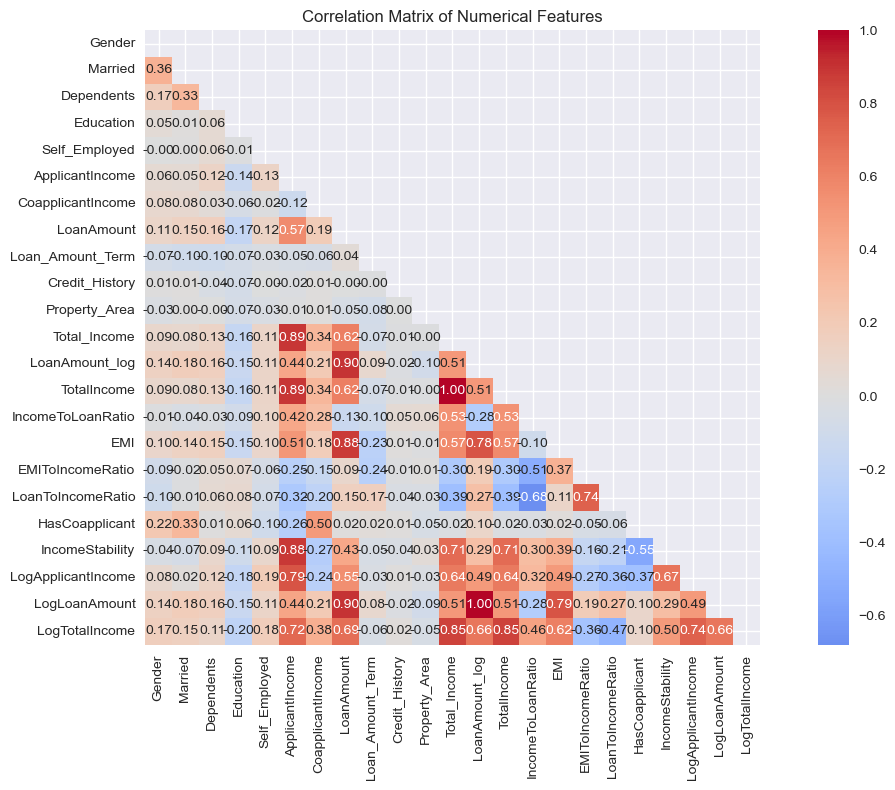


High Correlations (|r| > 0.7):
  ApplicantIncome - Total_Income: 0.893
  ApplicantIncome - TotalIncome: 0.893
  ApplicantIncome - IncomeStability: 0.882
  ApplicantIncome - LogApplicantIncome: 0.791
  ApplicantIncome - LogTotalIncome: 0.718
  LoanAmount - LoanAmount_log: 0.896
  LoanAmount - EMI: 0.876
  LoanAmount - LogLoanAmount: 0.898
  Total_Income - TotalIncome: 1.000
  Total_Income - IncomeStability: 0.711
  Total_Income - LogTotalIncome: 0.853
  LoanAmount_log - EMI: 0.784
  LoanAmount_log - LogLoanAmount: 1.000
  TotalIncome - IncomeStability: 0.711
  TotalIncome - LogTotalIncome: 0.853
  EMI - LogLoanAmount: 0.786
  EMIToIncomeRatio - LoanToIncomeRatio: 0.743
  LogApplicantIncome - LogTotalIncome: 0.740

ENGINEERED FEATURES ANALYSIS
Engineered features found: ['Total_Income', 'LoanAmount_log']

--- Total_Income ---
Range: -0.87 to 11.46
Mean: 0.00
Median: -0.25
Standard Deviation: 1.00


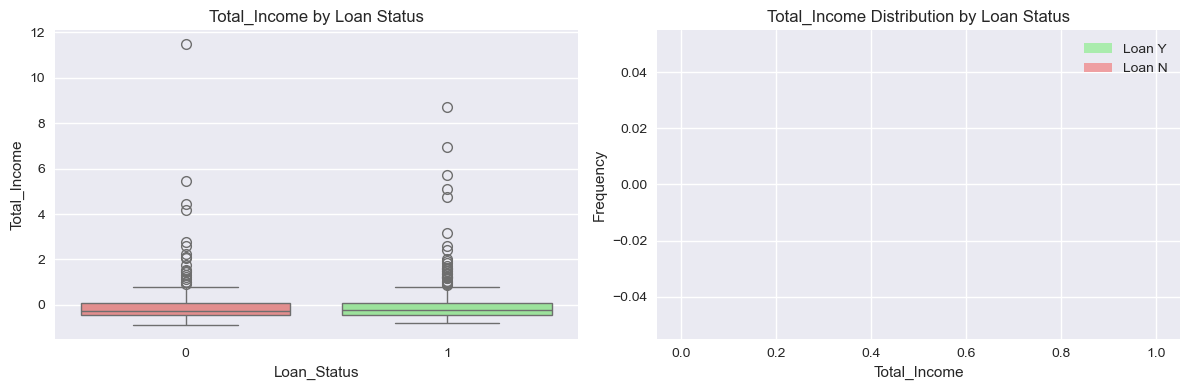

T-test between Loan Status groups: t-statistic = nan, p-value = nan

--- LoanAmount_log ---
Range: -5.37 to 3.42
Mean: 0.00
Median: -0.01
Standard Deviation: 1.00


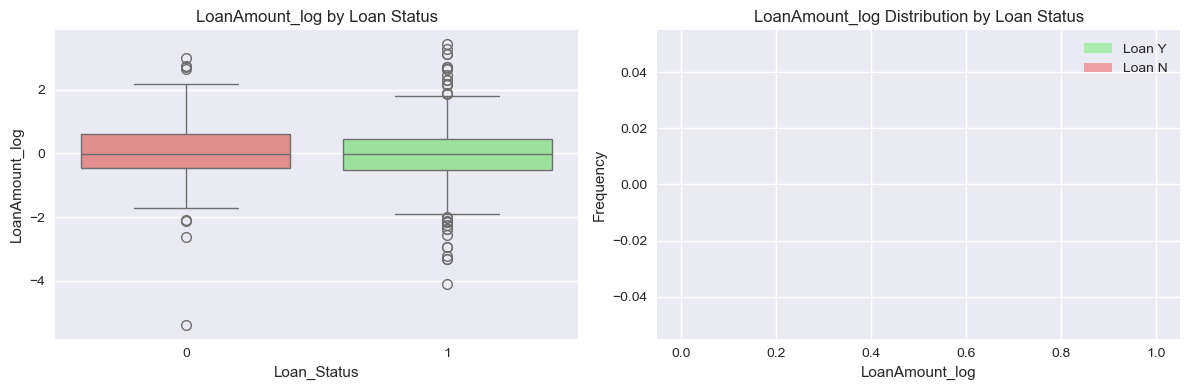

T-test between Loan Status groups: t-statistic = nan, p-value = nan


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def enhanced_eda(df):
    """
    Perform comprehensive exploratory data analysis
    """
    print("=" * 50)
    print("ENHANCED EXPLORATORY DATA ANALYSIS")
    print("=" * 50)
    
    # Basic information
    print(f"Dataset Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print("\n" + "=" * 30)
    print("DATA TYPES")
    print("=" * 30)
    print(df.dtypes)
    
    # Missing values
    print("\n" + "=" * 30)
    print("MISSING VALUES")
    print("=" * 30)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Target variable analysis
    if 'Loan_Status' in df.columns:
        print("\n" + "=" * 30)
        print("TARGET VARIABLE ANALYSIS")
        print("=" * 30)
        target_counts = df['Loan_Status'].value_counts()
        target_pct = df['Loan_Status'].value_counts(normalize=True) * 100
        target_summary = pd.DataFrame({
            'Count': target_counts,
            'Percentage': target_pct
        })
        print(target_summary)
        
        # Visualize target distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
                colors=['lightgreen', 'lightcoral'])
        plt.title('Loan Status Distribution')
        
        plt.subplot(1, 2, 2)
        sns.countplot(data=df, x='Loan_Status', palette=['lightcoral', 'lightgreen'])
        plt.title('Loan Status Count')
        
        plt.tight_layout()
        plt.show()
    
    # Numerical features analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Loan_Status' in numerical_cols:
        numerical_cols.remove('Loan_Status')
    
    if numerical_cols:
        print("\n" + "=" * 30)
        print("NUMERICAL FEATURES SUMMARY")
        print("=" * 30)
        print(df[numerical_cols].describe())
        
        # Distribution of numerical features
        print("\n" + "=" * 30)
        print("NUMERICAL FEATURES DISTRIBUTION")
        print("=" * 30)
        
        n_cols = min(3, len(numerical_cols))
        n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i, col in enumerate(numerical_cols):
            if i < len(axes):
                df[col].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue')
                axes[i].set_title(f'Distribution of {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')
        
        # Hide empty subplots
        for i in range(len(numerical_cols), len(axes)):
            axes[i].set_visible(False)
            
        plt.tight_layout()
        plt.show()
    
    # Categorical features analysis (excluding target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'Loan_Status' in categorical_cols:
        categorical_cols.remove('Loan_Status')
    
    if categorical_cols:
        print("\n" + "=" * 30)
        print("CATEGORICAL FEATURES ANALYSIS")
        print("=" * 30)
        
        for col in categorical_cols:
            print(f"\n{col}:")
            value_counts = df[col].value_counts()
            for value, count in value_counts.items():
                pct = (count / len(df)) * 100
                print(f"  {value}: {count} ({pct:.1f}%)")
    
    # Correlation analysis for numerical features
    if len(numerical_cols) > 1:
        print("\n" + "=" * 30)
        print("CORRELATION MATRIX")
        print("=" * 30)
        
        correlation_matrix = df[numerical_cols].corr()
        
        plt.figure(figsize=(12, 8))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f')
        plt.title('Correlation Matrix of Numerical Features')
        plt.tight_layout()
        plt.show()
        
        # Find high correlations
        high_corr = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                if abs(correlation_matrix.iloc[i, j]) > 0.7:
                    high_corr.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        correlation_matrix.iloc[i, j]
                    ))
        
        if high_corr:
            print("\nHigh Correlations (|r| > 0.7):")
            for feat1, feat2, corr in high_corr:
                print(f"  {feat1} - {feat2}: {corr:.3f}")

def analyze_engineered_features(df):
    """
    Analyze the engineered features specifically
    """
    print("\n" + "=" * 50)
    print("ENGINEERED FEATURES ANALYSIS")
    print("=" * 50)
    
    # Check if engineered features exist
    engineered_features = ['Total_Income', 'LoanAmount_log']
    existing_engineered = [feat for feat in engineered_features if feat in df.columns]
    
    if not existing_engineered:
        print("No engineered features found in the dataset.")
        return
    
    print(f"Engineered features found: {existing_engineered}")
    
    # Analyze each engineered feature
    for feature in existing_engineered:
        print(f"\n--- {feature} ---")
        print(f"Range: {df[feature].min():.2f} to {df[feature].max():.2f}")
        print(f"Mean: {df[feature].mean():.2f}")
        print(f"Median: {df[feature].median():.2f}")
        print(f"Standard Deviation: {df[feature].std():.2f}")
        
        # Check relationship with target
        if 'Loan_Status' in df.columns:
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            sns.boxplot(data=df, x='Loan_Status', y=feature, palette=['lightcoral', 'lightgreen'])
            plt.title(f'{feature} by Loan Status')
            
            plt.subplot(1, 2, 2)
            # Histogram by loan status
            for status, color in zip(['Y', 'N'], ['lightgreen', 'lightcoral']):
                subset = df[df['Loan_Status'] == status]
                plt.hist(subset[feature], alpha=0.7, label=f'Loan {status}', 
                        color=color, bins=30)
            plt.xlabel(feature)
            plt.ylabel('Frequency')
            plt.title(f'{feature} Distribution by Loan Status')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Statistical test
            group_y = df[df['Loan_Status'] == 'Y'][feature]
            group_n = df[df['Loan_Status'] == 'N'][feature]
            
            t_stat, p_value = stats.ttest_ind(group_y, group_n, nan_policy='omit')
            print(f"T-test between Loan Status groups: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Now run the analysis
print("Final check of processed data:")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")
print(f"Train columns: {train_processed.columns.tolist()}")
print(f"Loan_Status in train: {'Loan_Status' in train_processed.columns}")

if 'Loan_Status' in train_processed.columns:
    print(f"\nLoan_Status values: {train_processed['Loan_Status'].unique()}")
    print(f"Loan_Status distribution:\n{train_processed['Loan_Status'].value_counts()}")
    
    # Run the enhanced EDA
    enhanced_eda(train_processed)
    
    # Analyze engineered features
    analyze_engineered_features(train_processed)
else:
    print("\nERROR: Loan_Status column is missing from processed training data!")
    print("Available columns:", train_processed.columns.tolist())

### Advanced Model Building with Ensemble and Hyperparameter Tuning

In [19]:
class AdvancedLoanPredictor:
    def __init__(self):
        self.models = {
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
            'RandomForest': RandomForestClassifier(random_state=42),
            'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
            'GradientBoosting': GradientBoostingClassifier(random_state=42),
            'SVM': SVC(probability=True, random_state=42)
        }
        
        self.param_grids = {
            'LogisticRegression': {
                'C': [0.1, 1, 10],
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']
            },
            'RandomForest': {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5]
            },
            'XGBoost': {
                'n_estimators': [100, 200],
                'max_depth': [3, 6],
                'learning_rate': [0.01, 0.1]
            }
        }
        
        self.best_models = {}
        self.cv_results = {}
        
    def prepare_data(self, df, target_col='Loan_Status'):
        """Prepare features and target"""
        X = df.drop(columns=[target_col])
        y = df[target_col]
        return X, y
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Comprehensive model evaluation"""
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        print(f"\n{model_name} Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} - Confusion Matrix')
        
        # Feature Importance (for tree-based models)
        if hasattr(model, 'feature_importances_'):
            plt.subplot(1, 3, 2)
            feature_importance = pd.DataFrame({
                'feature': X_test.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=True).tail(10)
            
            plt.barh(feature_importance['feature'], feature_importance['importance'])
            plt.title(f'{model_name} - Top 10 Feature Importance')
        
        # ROC Curve
        plt.subplot(1, 3, 3)
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return accuracy, auc_score
    
    def train_models(self, X_train, y_train, X_val, y_val, use_smote=True):
        """Train multiple models with hyperparameter tuning"""
        results = {}
        
        if use_smote:
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            print(f"Before SMOTE: {np.bincount(y_train)}")
            print(f"After SMOTE: {np.bincount(y_train_resampled)}")
            X_train_final, y_train_final = X_train_resampled, y_train_resampled
        else:
            X_train_final, y_train_final = X_train, y_train
        
        for name, model in self.models.items():
            print(f"\n{'='*50}")
            print(f"Training {name}")
            print(f"{'='*50}")
            
            try:
                if name in self.param_grids:
                    # Hyperparameter tuning
                    grid_search = GridSearchCV(
                        model, self.param_grids[name], 
                        cv=5, scoring='roc_auc', n_jobs=-1
                    )
                    grid_search.fit(X_train_final, y_train_final)
                    best_model = grid_search.best_estimator_
                    self.best_models[name] = best_model
                    print(f"Best parameters: {grid_search.best_params_}")
                else:
                    # Standard training
                    model.fit(X_train_final, y_train_final)
                    self.best_models[name] = model
                
                # Evaluate on validation set
                accuracy, auc_score = self.evaluate_model(
                    self.best_models[name], X_val, y_val, name
                )
                
                results[name] = {
                    'accuracy': accuracy,
                    'auc_score': auc_score,
                    'model': self.best_models[name]
                }
                
            except Exception as e:
                print(f"Error training {name}: {e}")
                continue
        
        return results
    
    def create_ensemble(self, results, X_val, y_val):
        """Create ensemble model from best performers"""
        # Select top 3 models by AUC score
        top_models = sorted(results.items(), key=lambda x: x[1]['auc_score'], reverse=True)[:3]
        
        print("\nTop models for ensemble:")
        for name, metrics in top_models:
            print(f"{name}: AUC = {metrics['auc_score']:.4f}")
        
        # Simple voting ensemble
        class VotingEnsemble:
            def __init__(self, models):
                self.models = models
                
            def predict_proba(self, X):
                probas = [model.predict_proba(X) for model in self.models]
                return np.mean(probas, axis=0)
            
            def predict(self, X):
                probas = self.predict_proba(X)
                return (probas[:, 1] > 0.5).astype(int)
        
        ensemble_models = [metrics['model'] for name, metrics in top_models]
        ensemble = VotingEnsemble(ensemble_models)
        
        # Evaluate ensemble
        accuracy, auc_score = self.evaluate_model(ensemble, X_val, y_val, "Voting Ensemble")
        
        results['Ensemble'] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'model': ensemble
        }
        
        return results

# Prepare data for modeling
predictor = AdvancedLoanPredictor()
X, y = predictor.prepare_data(train_processed)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Data shapes:
X_train: (491, 23), y_train: (491,)
X_val: (123, 23), y_val: (123,)


### Model Training and Evaluation

  File "C:\Users\sg200\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\sg200\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\sg200\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\sg200\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Before SMOTE: [154 337]
After SMOTE: [337 337]

Training LogisticRegression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

LogisticRegression Performance:
Accuracy: 0.8618
AUC Score: 0.8734

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        38
           1       0.89      0.92      0.90        85

    accuracy                           0.86       123
   macro avg       0.84      0.83      0.83       123
weighted avg       0.86      0.86      0.86       123



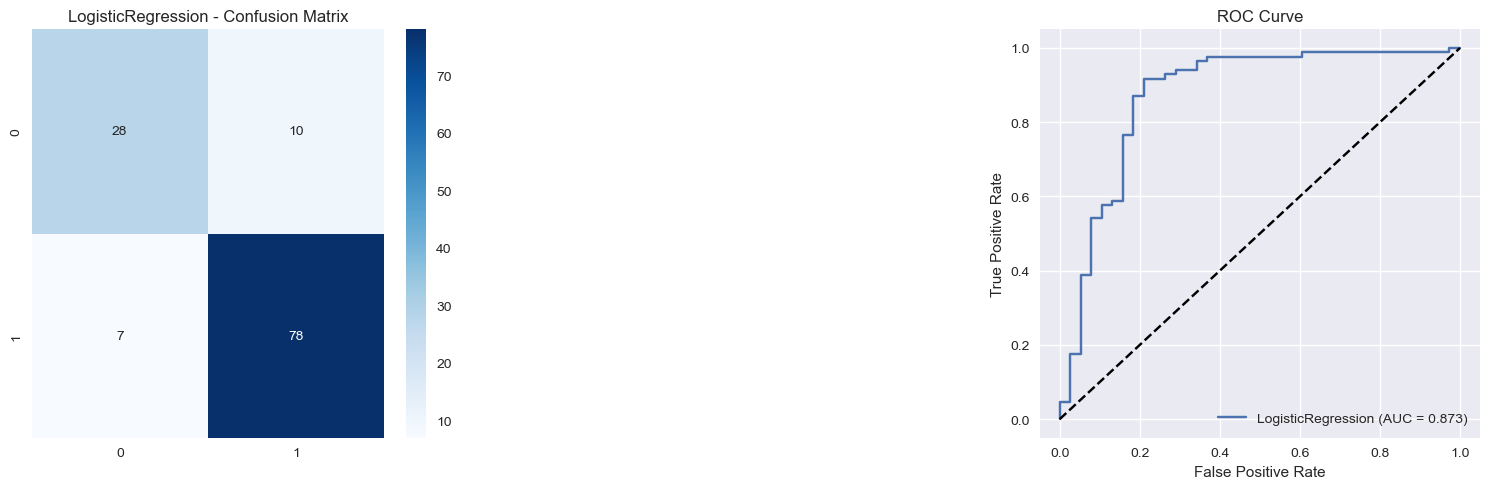


Training RandomForest
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

RandomForest Performance:
Accuracy: 0.8049
AUC Score: 0.8638

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        38
           1       0.88      0.84      0.86        85

    accuracy                           0.80       123
   macro avg       0.77      0.79      0.78       123
weighted avg       0.81      0.80      0.81       123



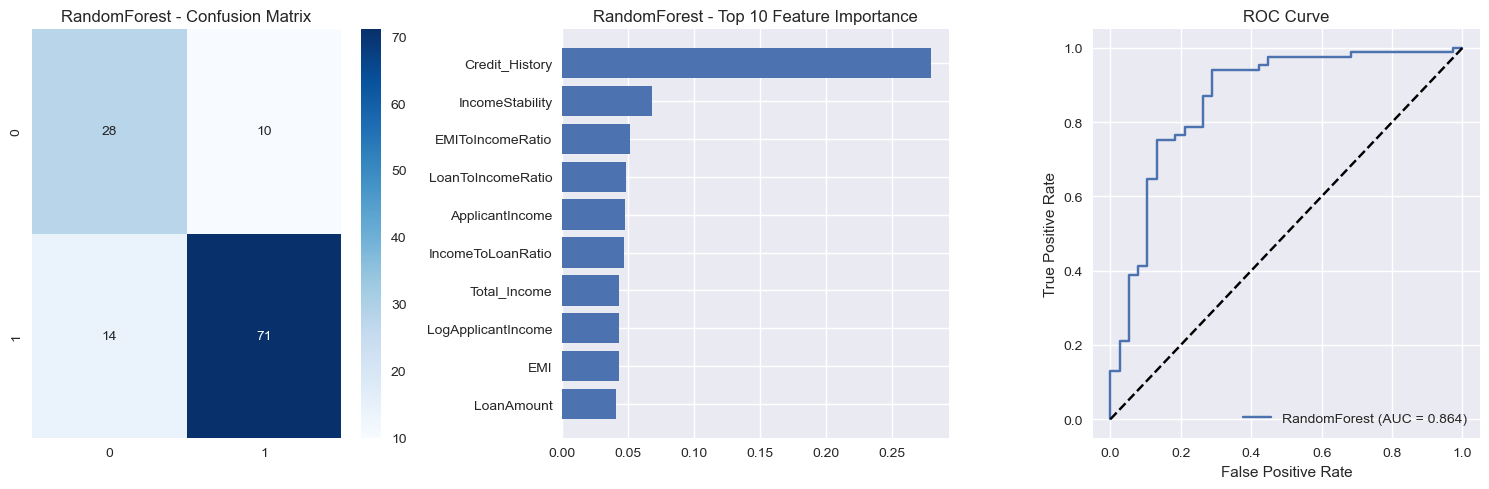


Training XGBoost
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

XGBoost Performance:
Accuracy: 0.7886
AUC Score: 0.8460

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68        38
           1       0.87      0.81      0.84        85

    accuracy                           0.79       123
   macro avg       0.75      0.77      0.76       123
weighted avg       0.80      0.79      0.79       123



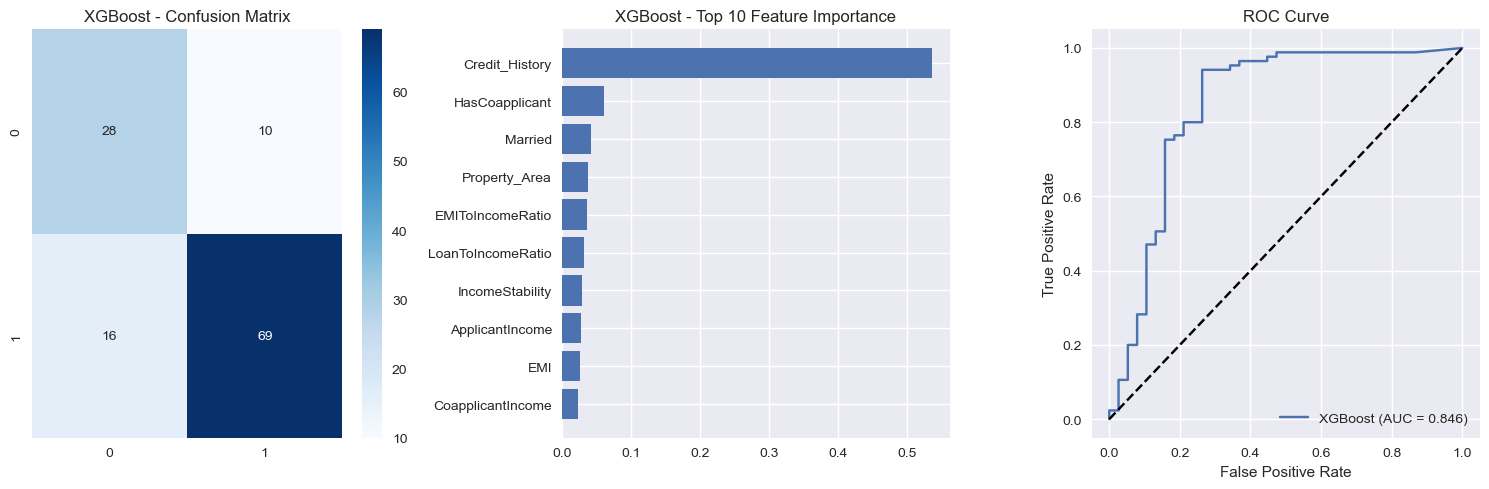


Training GradientBoosting

GradientBoosting Performance:
Accuracy: 0.7967
AUC Score: 0.8565

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        38
           1       0.88      0.82      0.85        85

    accuracy                           0.80       123
   macro avg       0.76      0.78      0.77       123
weighted avg       0.81      0.80      0.80       123



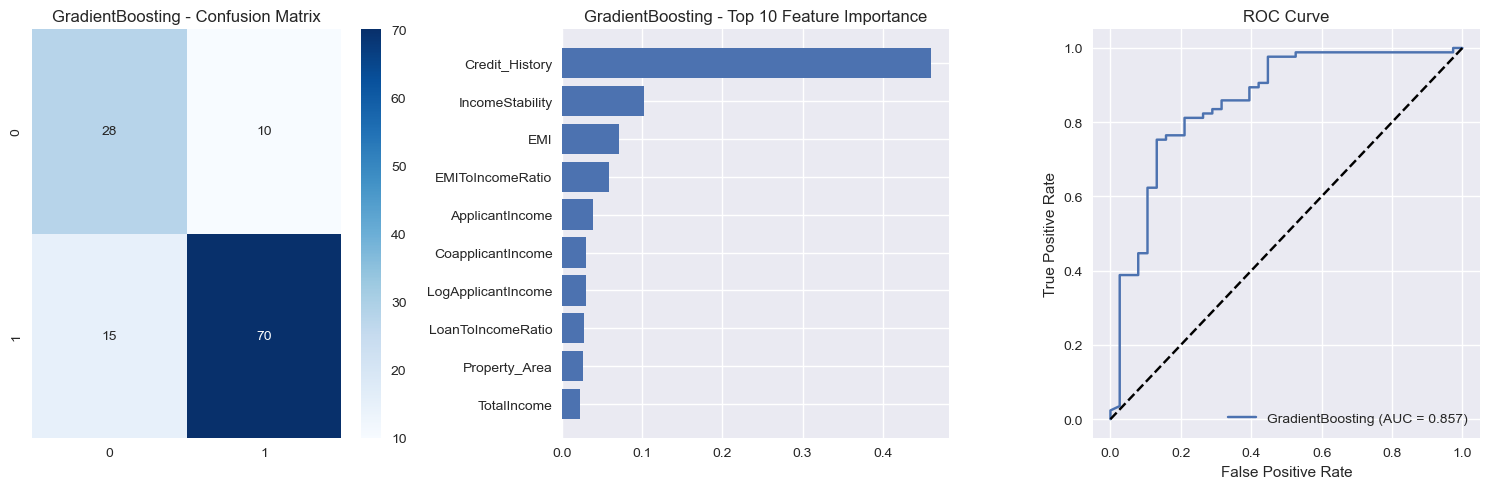


Training SVM

SVM Performance:
Accuracy: 0.8537
AUC Score: 0.8539

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        38
           1       0.85      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.78      0.81       123
weighted avg       0.86      0.85      0.84       123



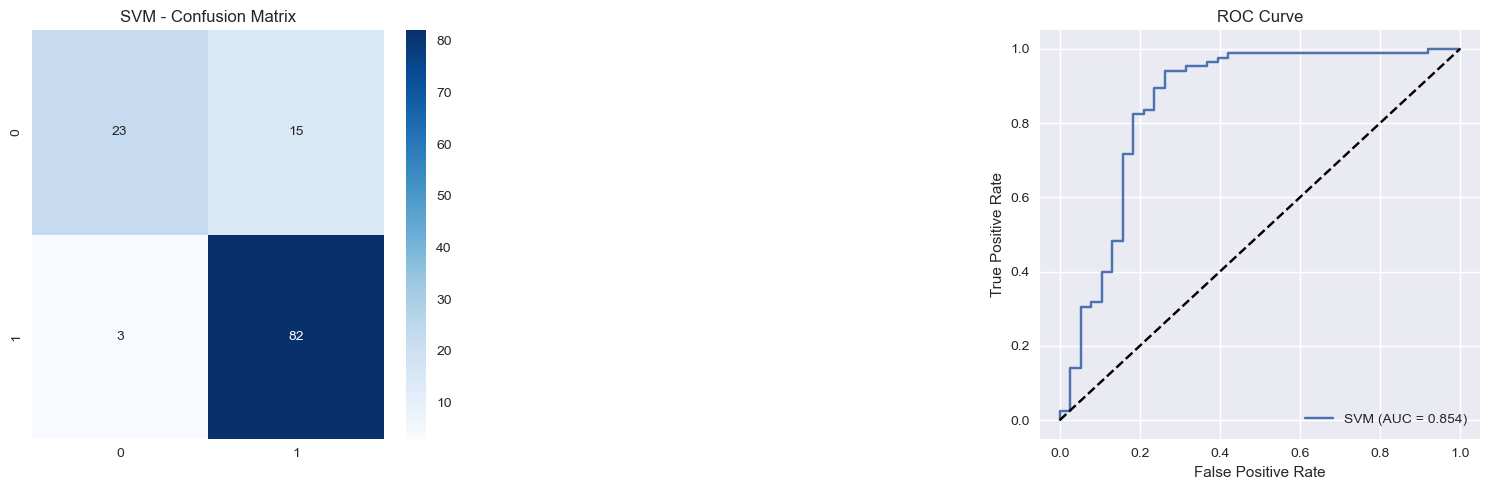


Top models for ensemble:
LogisticRegression: AUC = 0.8734
RandomForest: AUC = 0.8638
GradientBoosting: AUC = 0.8565

Voting Ensemble Performance:
Accuracy: 0.8618
AUC Score: 0.8793

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        38
           1       0.90      0.89      0.90        85

    accuracy                           0.86       123
   macro avg       0.84      0.84      0.84       123
weighted avg       0.86      0.86      0.86       123



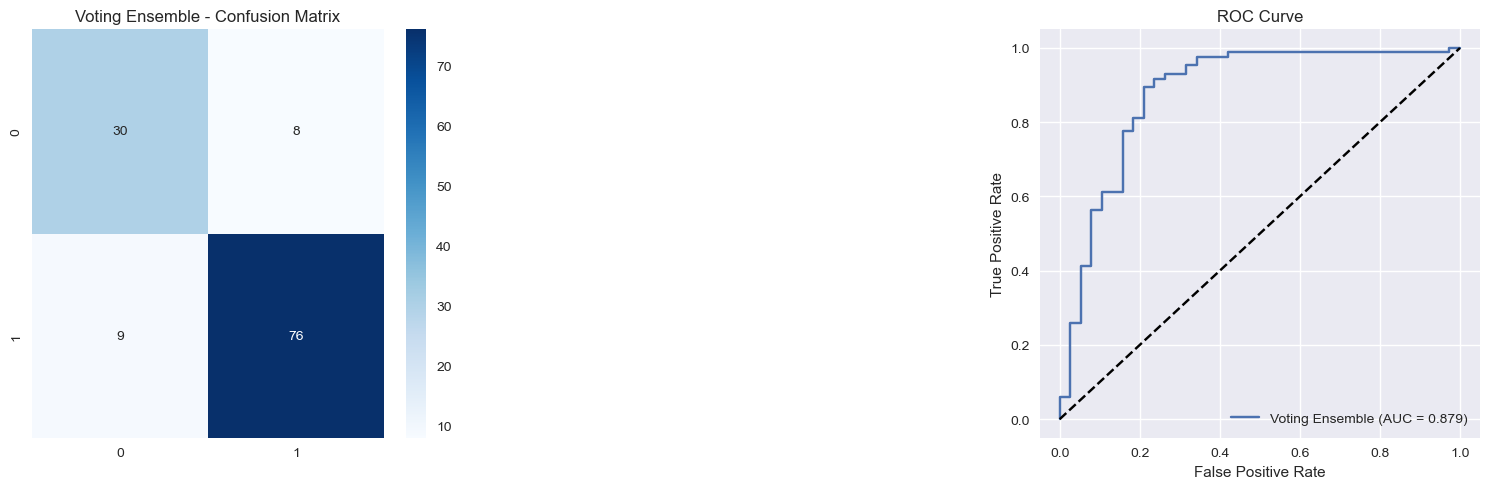


FINAL MODEL COMPARISON
                Model  Accuracy  AUC_Score
5            Ensemble  0.861789   0.879257
0  LogisticRegression  0.861789   0.873375
1        RandomForest  0.804878   0.863777
3    GradientBoosting  0.796748   0.856502
4                 SVM  0.853659   0.853870
2             XGBoost  0.788618   0.845975

🎯 Best Model: Ensemble


In [20]:
# Train and evaluate models
results = predictor.train_models(X_train, y_train, X_val, y_val, use_smote=True)

# Create ensemble
results = predictor.create_ensemble(results, X_val, y_val)

# Display final results
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'AUC_Score': [results[model]['auc_score'] for model in results]
}).sort_values('AUC_Score', ascending=False)

print(comparison_df)

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n🎯 Best Model: {best_model_name}")

### Cross-Validation for Robust Evaluation

In [ ]:
def perform_cross_validation(model, X, y, n_splits=5):
    """Perform stratified k-fold cross-validation"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {'accuracy': [], 'auc': []}
    
    print(f"\nPerforming {n_splits}-fold Cross-Validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        # Handle class imbalance with SMOTE
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)
        
        # Train model
        model_cv = model.__class__(**model.get_params())
        model_cv.fit(X_train_resampled, y_train_resampled)
        
        # Predict and score
        y_pred = model_cv.predict(X_val_cv)
        y_pred_proba = model_cv.predict_proba(X_val_cv)[:, 1]
        
        accuracy = accuracy_score(y_val_cv, y_pred)
        auc_score = roc_auc_score(y_val_cv, y_pred_proba)
        
        cv_scores['accuracy'].append(accuracy)
        cv_scores['auc'].append(auc_score)
        
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}, AUC = {auc_score:.4f}")
    
    print(f"\nCross-Validation Results:")
    print(f"Mean Accuracy: {np.mean(cv_scores['accuracy']):.4f} (+/- {np.std(cv_scores['accuracy']):.4f})")
    print(f"Mean AUC: {np.mean(cv_scores['auc']):.4f} (+/- {np.std(cv_scores['auc']):.4f})")
    
    return cv_scores

# Perform cross-validation on best model
cv_scores = perform_cross_validation(best_model, X, y)


Performing 5-fold Cross-Validation...


### Final Predictions and Submission

In [ ]:
def create_submission(model, test_processed, test_original, model_name):
    """Create submission file with predictions"""
    
    # Ensure test data has the same columns as training data
    missing_cols = set(X.columns) - set(test_processed.columns)
    for col in missing_cols:
        test_processed[col] = 0
    
    # Reorder columns to match training data
    test_processed = test_processed[X.columns]
    
    # Make predictions
    test_predictions = model.predict(test_processed)
    test_probabilities = model.predict_proba(test_processed)[:, 1]
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'Loan_ID': test_original['Loan_ID'],
        'Loan_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions],
        'Probability_Approval': test_probabilities
    })
    
    # Save submission file
    submission_file = f'loan_prediction_submission_{model_name}.csv'
    submission[['Loan_ID', 'Loan_Status']].to_csv(submission_file, index=False)
    
    print(f"\nSubmission file '{submission_file}' created!")
    print(f"Predictions distribution:")
    print(submission['Loan_Status'].value_counts())
    
    return submission

# Create final submission
final_submission = create_submission(best_model, test_processed, test_df, best_model_name.replace(' ', '_'))

# Display sample predictions
print("\nSample predictions:")
print(final_submission.head(10))

In [ ]:
try:
    import shap
    
    def explain_model(model, X_train, feature_names):
        """Explain model predictions using SHAP"""
        print("\n" + "="*50)
        print("MODEL EXPLANATION WITH SHAP")
        print("="*50)
        
        # Create explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
        plt.title('SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Force plot for a single prediction
        plt.figure(figsize=(12, 6))
        shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], 
                       feature_names=feature_names, matplotlib=True, show=False)
        plt.title('SHAP Force Plot for First Instance')
        plt.tight_layout()
        plt.show()
        
        # Feature importance DataFrame
        shap_df = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(shap_values).mean(0)
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 Most Important Features:")
        print(shap_df.head(10))
        
    # Explain the best model if it's tree-based
    if hasattr(best_model, 'feature_importances_'):
        explain_model(best_model, X_train, X.columns.tolist())
        
except ImportError:
    print("\nSHAP not installed. Install with: pip install shap")